In [1]:
import torch
import pandas as pd
import scanpy as sc
import os
import glob
import numpy as np
import stadiffuser.utils as stutils
import importlib
from stadiffuser import pipeline, metrics
from diffusers import DDPMScheduler
import warnings
import scipy
import gzip
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import rdata
from torch_geometric.loader import NeighborLoader
from _utils import *
from stadiffuser.pipeline import get_recon


method_palette = {
    'splatter':  '#8A98B8',  # Blue
    'kersplatter': '#B5BDD2',  # Lighter blue
    'zinb_spatial': "#EBAB71",  # coral
    'SRT_domain':  '#8CCF87',  # Green
    'scDesign': '#C0AFE2',  # Purple
    'stadiff': '#EA6666',  #coral
    "stadiff_label": "#EA6666", #lighter red #CF4144
}

warnings.filterwarnings("ignore")
os.environ["R_HOME"] = r"D:\Program Files\R\R-4.0.3"
sns.set_theme("paper", style="ticks", font_scale=1.5)


def find_file_path(path, end_pattern):
    matched_path = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(end_pattern)]
    if len(matched_path) == 0:
        raise ValueError("No file end with {} in {}".format(end_pattern, path))
    elif len(matched_path) > 1:
        raise ValueError("More than one file end with {} in {}".format(end_pattern, path))
    else:
        return matched_path[0]

def read_mtx(path):
    # read file "matrix.mtx.gz" in path
    # matrix.mtx.gz is not log2 transformed
    file = os.path.join(path, "matrix.mtx.gz")
    # read into dataframe
    with gzip.open(file, "rb") as f:
        mtx = scipy.io.mmread(f)
    mtx = scipy.sparse.csr_matrix(mtx)
    return mtx

In [3]:
def load_slide_tag(path, top_genes=2000, save_folder=None, kept_genes=None):
    barcodes = pd.read_csv(os.path.join(path, "barcodes.tsv.gz"), header=None)
    features = pd.read_csv(find_file_path(path, "features.tsv.gz"), index_col=0, header=None, sep="\t")
    raw_count = read_mtx(path)
    raw_count = pd.DataFrame.sparse.from_spmatrix(raw_count.T)
    raw_count.index = barcodes[0]
    raw_count.columns = features.iloc[:, 0]
    # print raw_count shape
    print("Raw count shape: ", raw_count.shape)
    spatial = pd.read_csv(find_file_path(path, "spatial.csv"), header=1)
    spatial.columns = ["barcode", "x", "y", "celltype"]
    # subset raw_count by spatial
    raw_count = raw_count.loc[spatial["barcode"]]
    # create anndata
    obs = pd.DataFrame(index=spatial["barcode"])
    obs.index.name = None
    obs["celltype"] = spatial["celltype"].values
    var = pd.DataFrame(index=features.iloc[:, 0])
    var.index.name = None
    adata = sc.AnnData(raw_count, obs=obs, var=var)
    adata.var_names_make_unique()
    adata.obsm["spatial"] = spatial[["x", "y"]].values
    # keep top 3000 genes
    raw_count = adata.X.copy()
    # nomarlize by total count
    sc.pp.normalize_total(adata, target_sum=1e4)
    # log1p
    sc.pp.log1p(adata)
    adata_temp = adata.copy()
    # if kept genes is not None, then remove the genes in kept_genes from adata_temp
    if kept_genes is not None:
        adata_temp = adata_temp[:, ~adata_temp.var.index.isin(kept_genes)].copy()
        # now we have to keep top_genes - len(kept_genes) genes
        top_genes = top_genes - len(kept_genes)
        sc.pp.highly_variable_genes(adata_temp, n_top_genes=top_genes, flavor="seurat")
        # concatenate the kept_genes and highly_variable genes
        remained_genes = adata_temp.var_names[adata_temp.var["highly_variable"]].values
        remained_genes = np.concatenate([remained_genes, np.array(kept_genes)])
    else:
        sc.pp.highly_variable_genes(adata_temp, n_top_genes=top_genes, flavor="seurat")
        remained_genes = adata_temp.var_names[adata_temp.var["highly_variable"]].values
    adata_raw = adata.copy()
    adata_raw.X = raw_count
    adata_raw = adata_raw[:, remained_genes]
    adata = adata[:, remained_genes]
    if save_folder is not None:
        print("Saving to {}".format(save_folder))
        adata.write_h5ad(os.path.join(save_folder, "adata_processed.h5ad"))
        adata_raw.write_h5ad(os.path.join(save_folder, "adata_raw.h5ad"))
    return adata, adata_raw
# SCP2162 failed
# SCP2169 success Human Tonsil
# SCP2171 success Human Melanoma
path = "../dataset/slide-tag/SCP2171"
output_root = "../output/App3-SCP2171"
figure_dir = "{}/_figures".format(output_root)
os.makedirs(figure_dir, exist_ok=True)
# read file end with "_expression.csv.gz" in path
# _expression.csv.gz is already log2 transformed
score_genes = pd.read_csv("{}/mese-melan_genes.csv".format(output_root), index_col=None)

# Generate processed data

In [16]:
adata, adata_raw = load_slide_tag(path, top_genes=3000, save_folder=None, kept_genes=score_genes.Gene.tolist())
# adata = stutils.cal_spatial_net2D(adata, rad_cutoff=40)

Raw count shape:  (6466, 36601)


In [615]:
# peform VST transformation on adata
# create mask  with random
missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for r in missing_rates:
    np.random.seed(2024)
    mask = np.random.rand(adata.shape[0]) > r
    # convert mask to sparse matrix
    adata.obs["random_{}".format(r)] = mask
# save the adata to output_dir
adata = stutils.cal_spatial_net2D(adata, rad_cutoff=0)
adata_raw.obs = adata.obs.copy()
adata.write_h5ad(os.path.join(output_root, "adata_processed.h5ad"))
adata_raw.write_h5ad(os.path.join(output_root, "adata_raw.h5ad"))

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 6 edges, 4804 cells, 0.0012 neighbors per cell on average.


<Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

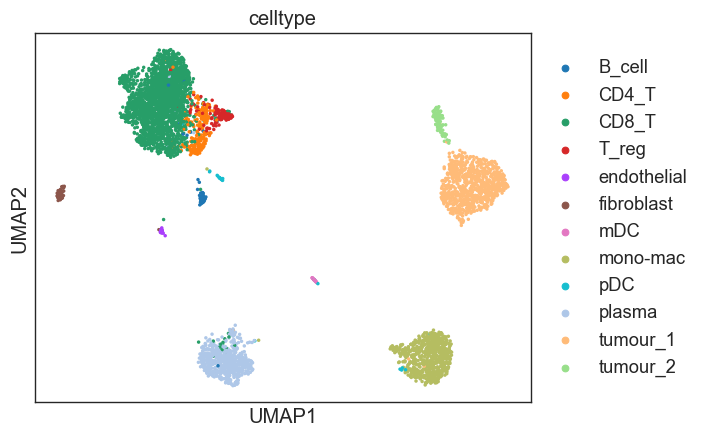

In [616]:
# perform pca
sc.tl.pca(adata, svd_solver="arpack")
# perform umap
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata, min_dist=0.5)
# plot umap
sc.pl.umap(adata, color="celltype", show=False)

In [13]:
new_spatial = adata.obsm["spatial"]
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 40), ("division", 40)])

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.025, mean deviation: 0.24489502416133196, pearson correlation: 0.9998819315978178
Quantize 1th dimension of spatial coordinates to 0.025, mean deviation: 0.24917380404188227, pearson correlation: 0.9997992879902013


In [3]:
autoencoder = torch.load("../output/App3-SCP2171/full_scale/autoencoder_attn2.pth")
adata_ = adata.copy()
sc.pp.scale(adata_)
adata_recon = get_recon(adata_, autoencoder, device="cuda:0", use_net="spatial_net", apply_normalize=False)
sc.pp.neighbors(adata_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_recon, min_dist=0.5)
# plot umap
sc.pl.umap(adata_recon, color="celltype", show=False)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 autoencoder = torch.load("../output/App3-SCP2171/full_scale/autoencoder_attn2.pth")          │
│   2 adata_ = adata.copy()                                                                        │
│   3 sc.pp.scale(adata_)                                                                          │
│   4 adata_recon = get_recon(adata_, autoencoder, device="cuda:0", use_net="spatial_net", app     │
│                                                                                                  │
│ C:\Users\001\anaconda3\envs\STADiffusion\lib\site-packages\torch\serialization.py:771 in load    │
│                                                                                                  │
│    768 │   if 'encoding' not in pickle_load_args.keys():                                         │
│    769 │   │   pickle_load_args['encoding'] = 'utf-8'                                            │
│    770 │                                                                                         │
│ ❱  771 │   with _open_file_like(f, 'rb') as opened_file:                                         │
│    772 │   │   if _is_zipfile(opened_file):                                                      │
│    773 │   │   │   # The zipfile reader is going to advance the current file position.           │
│    774 │   │   │   # If we want to actually tail call to torch.jit.load, we need to              │
│                                                                                                  │
│ C:\Users\001\anaconda3\envs\STADiffusion\lib\site-packages\torch\serialization.py:270 in         │
│ _open_file_like                                                                                  │
│                                                                                                  │
│    267                                                                                           │
│    268 def _open_file_like(name_or_buffer, mode):                                                │
│    269 │   if _is_path(name_or_buffer):                                                          │
│ ❱  270 │   │   return _open_file(name_or_buffer, mode)                                           │
│    271 │   else:                                                                                 │
│    272 │   │   if 'w' in mode:                                                                   │
│    273 │   │   │   return _open_buffer_writer(name_or_buffer)                                    │
│                                                                                                  │
│ C:\Users\001\anaconda3\envs\STADiffusion\lib\site-packages\torch\serialization.py:251 in         │
│ __init__                                                                                         │
│                                                                                                  │
│    248                                                                                           │
│    249 class _open_file(_opener):                                                                │
│    250 │   def __init__(self, name, mode):                                                       │
│ ❱  251 │   │   super(_open_file, self).__init__(open(name, mode))                                │
│    252 │                                                                                         │
│    253 │   def __exit__(self, *args):                                                            │
│    254 │   │   self.file_like.close()                                                            │
╰────────────────────────────────────────────────────────────

<Axes: title={'center': 'scaled'}, xlabel='UMAP1', ylabel='UMAP2'>

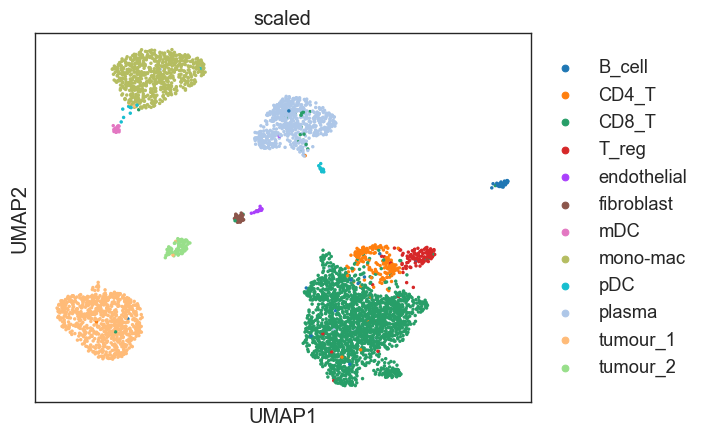

In [259]:
# apply umap
autoencoder = torch.load("../output/App3-SCP2171/full/autoencoder_attn2.pth")
adata_recon = get_recon(adata, autoencoder, device="cuda:0", use_net="spatial_net", apply_normalize=False)
sc.pp.neighbors(adata_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_recon, min_dist=0.5)
# plot umap
sc.pl.umap(adata_recon, color="celltype", show=False, title="scaled")

In [ ]:
# apply umap
autoencoder = torch.load("../output/App3-SCP2171/full/autoencoder_attn2.pth")
adata_recon = get_recon(adata, autoencoder, device="cuda:0", use_net="spatial_net", apply_normalize=False)
sc.pp.neighbors(adata_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_recon, min_dist=0.5)
# plot umap
sc.pl.umap(adata_recon, color="celltype", show=False, title="scaled")

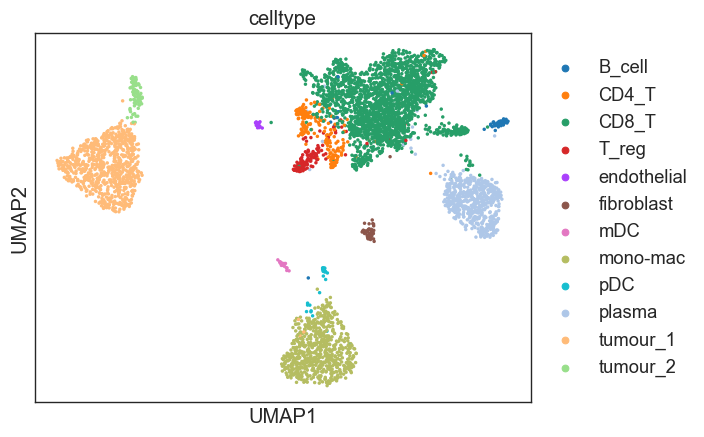

In [4]:
adata = sc.read_h5ad(os.path.join(path, "adata_processed.h5ad"))
# scale and center the adata
sc.pp.scale(adata, max_value=30)
# perform pca and umap
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)
# u
sc.pl.embedding(adata, basis="umap", color="celltype")

# Benchmark the simulation performance on full data (SCP2171)


In [5]:
n_rep = 5
output_dir = os.path.join(output_root, "full_bk")
adata = sc.read_h5ad(os.path.join(output_root, "adata_processed_bk.h5ad"))
adata_raw = sc.read_h5ad(os.path.join(output_root, "adata_raw_bk.h5ad"))
device = "cuda:0"
adata = stutils.cal_spatial_net2D(adata, rad_cutoff=0)
autoencoder = torch.load("{}/autoencoder_attn2.pth".format(output_dir)).to(device)
denoiser = torch.load("{}/denoiser.pth".format(output_dir)).to(device)
adata_real_recon = pipeline.get_recon(adata, autoencoder, apply_normalize=False, device=device)
normalizer = stutils.MinMaxNormalize(adata_real_recon.obsm["latent"], dim=0)
new_spatial = adata.obsm["spatial"].copy()
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 40), ("division", 40)])
adata.obsm["new_spatial"] = new_spatial

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 6 edges, 4804 cells, 0.0012 neighbors per cell on average.
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.025, mean deviation: 0.24489502416133196, pearson correlation: 0.9998819315978178
Quantize 1th dimension of spatial coordinates to 0.025, mean deviation: 0.24917380404188227, pearson correlation: 0.9997992879902013


<Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

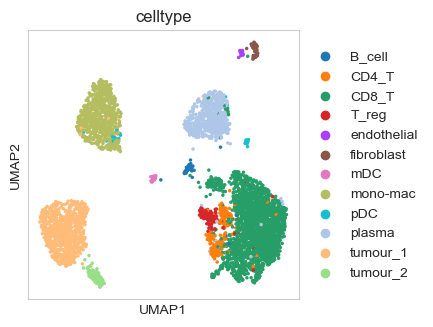

In [119]:
# plot umap
sc.pp.neighbors(adata_real_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_real_recon, min_dist=0.6)
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sc.pl.umap(adata_real_recon, color="celltype", ax=ax, show=False)

Text(0.5, 1.0, '')

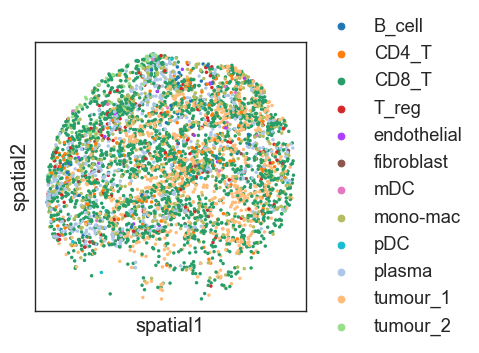

In [6]:
# plot spatial
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sc.pl.embedding(adata, basis="spatial", color="celltype", ax=ax, show=False)
# set title xlabel and ylabel to emtpy
ax.set_title("")
# ax.set_xlabel("")
# ax.set_ylabel("")
# save to disk
# fig.savefig("{}/full_spatial.png".format(figure_dir), dpi=300)

In [123]:
n_rep = 5
data = pipeline.prepare_dataset(adata, use_rep=None)
for i in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                    ref_data=adata, spatial_coord=adata.obsm["new_spatial"],
                                    seed=i, normarlizer=normalizer)
    stadiff_sim.write_h5ad( output_dir + "\stadiff_{}.h5ad".format(i))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
# simulate data with labels
cond_name = "celltype"
num_class_embeds = len(np.unique(adata.obs[cond_name]))
class_dict = dict(zip(np.unique(adata.obs[cond_name]), range(num_class_embeds)))
print("Class encoding: ")
print(class_dict)
adata.obs["encoded_label"] = adata.obs[cond_name].map(class_dict)
denoiser_label = torch.load("{}/denoiser_{}.pth".format(output_dir, cond_name)).to(device)

Class encoding: 
{'B_cell': 0, 'CD4_T': 1, 'CD8_T': 2, 'T_reg': 3, 'endothelial': 4, 'fibroblast': 5, 'mDC': 6, 'mono-mac': 7, 'pDC': 8, 'plasma': 9, 'tumour_1': 10, 'tumour_2': 11}


In [167]:
for i in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser_label, autoencoder, device=device, use_net="spatial_net",
                                    ref_data=adata, spatial_coord=adata.obsm["new_spatial"],
                                    labels = adata.obs["encoded_label"].to_numpy(),
                                    seed=i, normarlizer=normalizer)
    stadiff_sim.write_h5ad("{}/stadiff_label_{}.h5ad".format(output_dir, i))

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

## Compare with competing methods

In [26]:
comp_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff", "stadiff_label"]
comp_sim_dict = dict()
for comp_method in comp_methods:
    adata_list = [sc.read_h5ad("{}/{}_{}.h5ad".format(output_dir, comp_method, seed + 1)) for seed in range(n_rep)]
    comp_sim_dict[comp_method] = adata_list

In [169]:
gene_corr = dict()
for sim_name in comp_sim_dict:
    sim_adata = comp_sim_dict[sim_name][0].copy()
    sim_adata.uns["spatial_net"] = adata_real_recon.uns["spatial_net"]
    if sim_name == "stadiff_label" or sim_name == "stadiff":
        sim_adata_recon = sim_adata
    else:
        sim_adata.obs_names = adata.obs_names
        sim_adata.var_names = adata.var_names
        sim_adata.X = sim_adata.X.toarray()
        sim_adata.obsm["spatial"] = adata.obsm["spatial"]
        sim_adata_recon = pipeline.get_recon(sim_adata, autoencoder, device=device, use_net="spatial_net")
    gene_corr[sim_name] = metrics.compute_corr(sim_adata_recon, adata_real_recon, dim="gene")

In [179]:
sim_adata = comp_sim_dict["stadiff_label"][0]
# perform umap based on latent
sc.pp.neighbors(sim_adata, use_rep="latent", n_neighbors=30)
sc.tl.umap(sim_adata, min_dist=0.5)

<Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

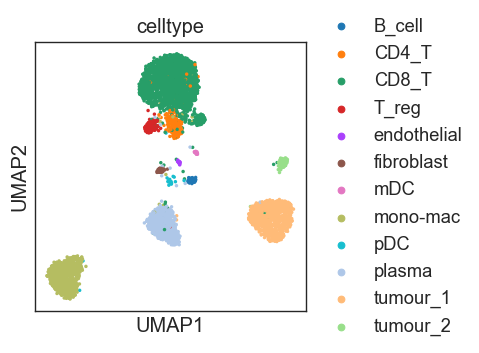

In [180]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sc.pl.umap(sim_adata, color="celltype", ax=ax, show=False)

### Compare the gene correlation

In [193]:
from _utils import *
method_palette = {
    'splatter':  '#1f78b4',  # Blue
    'kersplatter': '#a6cee3',  # Lighter blue
    'zinb_spatial': "#ff7f0e",  # coral
    'SRT_domain':  '#33a02c',  # Green
    'scDesign': '#6a3d9a',  # Purple
    'stadiff': '#e31a1c',  #red
    "stadiff_label": "#fb9a99", #lighter red  “#fb9a99”
}
sns.set_theme("paper", style="ticks", font_scale=1.5)

import itertools
def compute_sim_perf(sim_adata_list, autoencoder, adata_raw, adata_real_recon,
                     enhanced = False,
                     n_rep=5,
                     device="cuda:0"):
    sim_perf = dict()
    metric_names = ["cell_corr", "enhanced_cell_corr", "pairwise_cell_corr", "pairwise_enhanced_cell_corr"]
    metric_names += ["gene_corr", "enhanced_gene_corr", "pairwise_gene_corr", "pairwise_enhanced_gene_corr"]
    for name in metric_names:
        sim_perf[name] = []
    if not enhanced:
        adata_sim_recon_list = []
    else:
        adata_sim_recon_list = sim_adata_list
    for ind in range(n_rep):
        adata_sim = sim_adata_list[ind]
        if not enhanced:
            adata_sim_recon = get_recon(adata_sim, autoencoder, device=device, use_net="spatial_net")
            adata_sim_recon_list.append(adata_sim_recon)
        else:
            adata_sim_recon = adata_sim
        for dim in ["cell", "gene"]:
            sim_perf[dim + "_corr"].append(np.nanmean(metrics.compute_corr(adata_sim, adata_raw, dim=dim)))
            sim_perf["enhanced_" + dim + "_corr"].append(np.nanmean(metrics.compute_corr(adata_sim_recon, adata_real_recon, dim=dim)))

    for (i, j) in itertools.combinations(range(n_rep), 2):
        for dim in ["cell", "gene"]:
            sim_perf["pairwise_" + dim + "_corr"].append(np.nanmean(metrics.compute_corr(sim_adata_list[i], sim_adata_list[j], dim=dim)))
            sim_perf["pairwise_enhanced_" + dim + "_corr"].append(np.nanmean(metrics.compute_corr(adata_sim_recon_list[i], adata_sim_recon_list[j], dim=dim)))
    return sim_perf

### Gene correlation violin plot

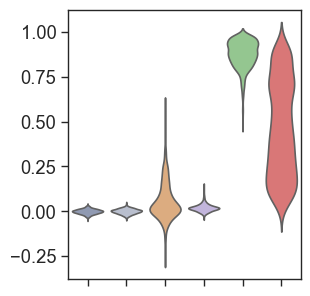

In [231]:
gene_corr_df = pd.DataFrame(gene_corr)
plot_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
gene_corr_df = gene_corr_df[plot_methods].melt(var_name="method", value_name="correlation")
# plot boxplot for gene correlation
fig, ax = plt.subplots(1, 1, figsize=(3, 3.5))
# plot violin plot with edge color different and filling is blank
sns.violinplot(x="method", y="correlation", data=gene_corr_df, ax=ax,  scale='width',
               inner=None, palette={method: method_palette[method] for method in plot_methods},
               color={method: method_palette[method] for method in plot_methods}, fill=False)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
# save to disk
fig.savefig("{}/full_gene_corr_violin.png".format(figure_dir), dpi=300)

In [25]:
comp_methods

['splatter',
 'kersplatter',
 'zinb_spatial',
 'scDesign',
 'SRT_domain',
 'stadiff',
 'stadiff_label']

In [34]:
# print the median of the gene correlation
# adata_raw.X = adata_raw.X.toarray()
comp_perf_dict = dict()
for name in comp_methods:
    print("==== {} ====".format(name))
    adata_list = comp_sim_dict[name]
    if name == "stadiff_label" or name == "stadiff":
        comp_perf_dict[name] = compute_sim_perf(comp_sim_dict[sim_name], autoencoder, adata_raw, adata_real_recon,
                                                    enhanced=True, n_rep=5, device=device)
    else:
        adata_temp_list = []
        for a in adata_list:
            a = a.copy()
            a.X = a.X.toarray()
            a.uns["spatial_net"] = adata.uns["spatial_net"]
            a.obsm["spatial"] = adata.obsm["spatial"]
            # set obs_name
            a.obs_names = adata.obs_names
            adata_temp_list.append(a)
        adata_list = adata_temp_list
        comp_perf_dict[name] = compute_sim_perf(adata_list, autoencoder, adata_raw, adata_real_recon,
                                               enhanced=False, n_rep=5, device=device)

==== splatter ====
==== kersplatter ====
==== zinb_spatial ====
==== scDesign ====
==== SRT_domain ====
==== stadiff ====
==== stadiff_label ====


In [207]:
metric_names = ["cell_corr", "enhanced_cell_corr", "pairwise_cell_corr", "pairwise_enhanced_cell_corr"]
metric_names += ["gene_corr", "enhanced_gene_corr", "pairwise_gene_corr", "pairwise_enhanced_gene_corr"]
perf_df = []
for sim_name in comp_methods:
    perf_df.append([np.nanmean(comp_perf_dict[sim_name][name]) for name in metric_names])
perf_df = pd.DataFrame(perf_df, index=comp_methods, columns=metric_names)
for group in ["cell", "gene"]:
    perf_df["enhanced_" + group + "_diversity"] = 1 - perf_df["pairwise_enhanced_" + group + "_corr"]
    perf_df[group + "_diversity"] = 1 - perf_df["pairwise_" + group + "_corr"]

In [213]:
perf_df

,cell_corr,enhanced_cell_corr,pairwise_cell_corr,pairwise_enhanced_cell_corr,gene_corr,enhanced_gene_corr,pairwise_gene_corr,pairwise_enhanced_gene_corr,enhanced_cell_diversity,cell_diversity,enhanced_gene_diversity,gene_diversity
splatter,0.000072,0.021064,0.000006,0.681771,0.000118,-0.001601,-0.000014,0.000879,0.318229,0.999994,0.999121,1.000014
kersplatter,-0.000452,0.027057,-0.000569,0.441662,-0.000061,-0.002334,-0.000248,0.000174,0.558338,1.000569,0.999826,1.000248
zinb_spatial,0.144649,0.027859,0.195938,0.885116,0.004566,0.058658,0.063121,0.229703,0.114884,0.804062,0.770297,0.936879
scDesign,0.102402,0.006374,0.094144,0.715321,0.005955,0.018280,0.005642,0.023234,0.284679,0.905856,0.976766,0.994358
SRT_domain,0.972365,0.687516,0.964824,0.995929,0.653087,0.872891,0.864780,0.985105,0.004071,0.035176,0.014895,0.135220
stadiff,-0.002799,0.036755,0.039301,0.039301,0.001659,0.006174,0.005538,0.005538,0.960699,0.960699,0.994462,0.994462
stadiff_label,0.267106,0.616656,0.568484,0.568484,0.146137,0.460565,0.430380,0.430380,0.431516,0.431516,0.569620,0.569620


### Plot the gene correlation vs gene diversity

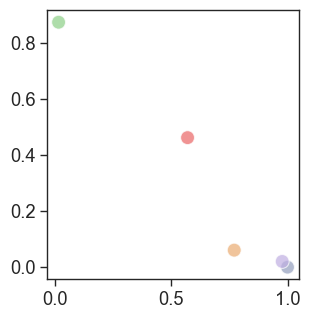

In [224]:
plot_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
plot_palette = {method: method_palette[method] for method in plot_methods}
plot_palette["stadiff_label"] = method_palette["stadiff"]
perf_df_drop = perf_df.loc[plot_methods]
fig, ax = plt.subplots(1, 1, figsize=(3.25, 3.5))
# set color palette
perf_df_drop["method"] = perf_df_drop.index
sns.scatterplot(data=perf_df_drop, x="enhanced_gene_diversity", y="enhanced_gene_corr",
                hue="method",
                ax=ax,
                style="method",
                palette=plot_palette,
                markers = "o",
                alpha=0.7,
                legend=False, s=100)
# show legend
# ax.set_ylim(0.2, 1)
ax.set_xlabel("")
ax.set_ylabel("")
# save to disk
fig.savefig("{}/full_gene_corr_diversity_vs_fidlity.png".format(figure_dir), dpi=300)
# set tick font size to 7
# save figure to file

### mLSI barplot

In [41]:
for method_name in comp_methods:
    print("Method: ", method_name)
    comp_perf_dict[method_name]["mLISI"] = []
    adata_sim = comp_sim_dict[method_name][0]
    if method_name == "stadiff_label" or method_name == "stadiff":
        adata_sim_recon = adata_sim
    else:
        adata_sim = adata_sim.copy()
        adata_sim.X = adata_sim.X.toarray()
        adata_sim.uns["spatial_net"] = adata.uns["spatial_net"]
        adata_sim.obsm["spatial"] = adata.obsm["spatial"]
        adata_sim.obs_names = adata.obs_names
        adata_sim_recon = get_recon(adata_sim, autoencoder, device=device, use_net="spatial_net")
    mlsi = metrics.compute_paired_lisi(adata_sim_recon, adata_real_recon)
    comp_perf_dict[method_name]["mLISI"].append(mlsi)
    print(np.mean(mlsi))

Method:  splatter
1.000883600820462
Method:  kersplatter
1.0048535313579952
Method:  zinb_spatial
1.0038771572270295
Method:  scDesign
1.0780857073144343
Method:  SRT_domain
1.8898957503699862
Method:  stadiff
1.0013784182863286
Method:  stadiff_label
1.003142349800275


[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, '')]

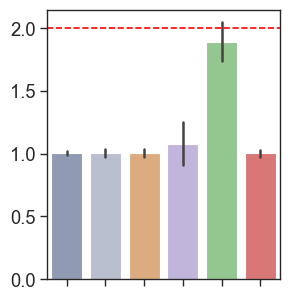

In [38]:
# plot barplot for mLISI
mLISI_df = []
plot_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
# add column to mLISI_df
for sim_name in plot_methods:
    mLISI_df.append(comp_perf_dict[sim_name]["mLISI"][0])
# convert to dataframe
mLISI_df = np.array(mLISI_df).squeeze().T
mLISI_df = pd.DataFrame(mLISI_df, columns=plot_methods)
fig, ax = plt.subplots(1, 1, figsize=(3, 3.5))
sns.barplot(data=mLISI_df, ax=ax,
            palette={method: method_palette[method] for method in plot_methods}, ci="sd")
# set a horizontal line at 2
ax.axhline(2, color="red", linestyle="--")
# set x label to empty and x axis to empty
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
# save to disk
# fig.savefig("{}/full_mLISI_barplot.png".format(figure_dir), dpi=300)

# Diffrential gene expression

In this section, we will perform differential gene expression (DEG) analysis on the simulated data and the real data. We will compare the:
- DEG on raw real data
- DEG on enhanced real data
- DEG on simulated data
TODO: plot the gene expression heatmap for the DEG genes

In [7]:
from scipy.cluster import hierarchy
from _utils import get_rep
device = "cuda:0"
adata = sc.read_h5ad(os.path.join(output_root, "adata_processed.h5ad"))
adata_raw = sc.read_h5ad(os.path.join(output_root, "adata_raw.h5ad"))
de_df = pd.read_csv(os.path.join(output_root, "Tumor_DE.csv"), index_col=0)
de_inter = set.intersection(set(de_df.index), set(adata.var_names))
autoencoder = torch.load("{}/full/autoencoder_attn2.pth".format(output_root)).to(device)
denoiser = torch.load("{}/full/denoiser_celltype.pth".format(output_root)).to(device)
adata_real_recon = pipeline.get_recon(adata, autoencoder, device=device, use_net="spatial_net", apply_normalize=False)
normalizer = stutils.MinMaxNormalize(adata_real_recon.obsm["latent"], dim=0)
new_spatial = adata.obsm["spatial"].copy()
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 40), ("division", 40)])
adata.obsm["new_spatial"] = new_spatial
data = pipeline.prepare_dataset(adata, use_rep=None)

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.025, mean deviation: 0.24489502416133196, pearson correlation: 0.9998819315978178
Quantize 1th dimension of spatial coordinates to 0.025, mean deviation: 0.24917380404188227, pearson correlation: 0.9997992879902013


In [8]:
cond_name = "celltype"
num_class_embeds = len(np.unique(adata.obs[cond_name]))
class_dict = dict(zip(np.unique(adata.obs[cond_name]), range(num_class_embeds)))
print(class_dict)
reverse_class_dict = {v: k for k, v in class_dict.items()}
encoded_label = adata.obs["celltype"].map(class_dict).to_numpy()
adata.obs["encoded_label"] = encoded_label

{'B_cell': 0, 'CD4_T': 1, 'CD8_T': 2, 'T_reg': 3, 'endothelial': 4, 'fibroblast': 5, 'mDC': 6, 'mono-mac': 7, 'pDC': 8, 'plasma': 9, 'tumour_1': 10, 'tumour_2': 11}


## UMAP and spatial plot

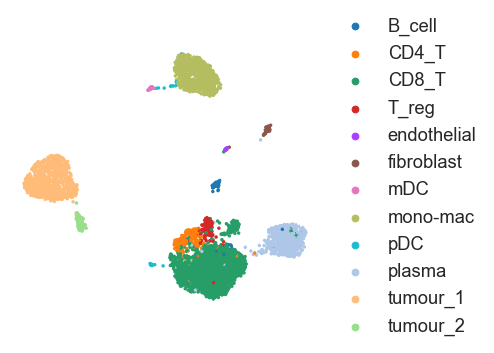

In [5]:
# plot umap
sc.pp.neighbors(adata_real_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_real_recon, min_dist=0.5)
fig, ax = plt.subplots(figsize=(4, 3.5))
sc.pl.umap(adata_real_recon, color="celltype", ax=ax, show=False, frameon=False)
# remove tile
ax.set_title("")
# save to figures
fig.savefig("{}/full_umap.png".format(figure_dir), dpi=300)

Text(0, 0.5, '')

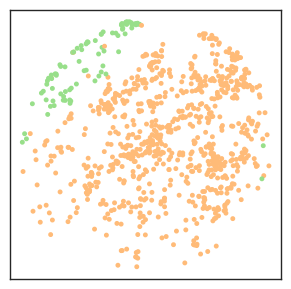

In [7]:
adata_sub = adata[adata.obs["celltype"].isin(["tumour_1", "tumour_2"])]
# plot spatial
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sc.pl.embedding(adata_sub, basis="spatial", color="celltype", ax=ax, show=False, s=50,
                palette={"tumour_1": sc.pl.palettes.vega_20_scanpy[10],
                         "tumour_2": sc.pl.palettes.vega_20_scanpy[11]}, legend_loc=None)
# set title xlabel and ylabel to emtpy
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
# save to disk
# fig.savefig("{}/full_tumour_1_tumour_2.png".format(figure_dir), dpi=300)

Text(0, 0.5, '')

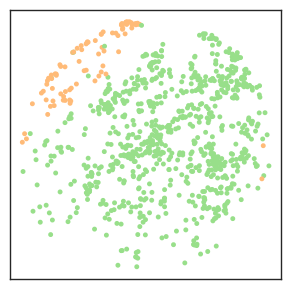

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sc.pl.embedding(adata_sub, basis="spatial", color="celltype", ax=ax, show=False, s=50,
                palette={"tumour_1": sc.pl.palettes.vega_20_scanpy[11],
                         "tumour_2": sc.pl.palettes.vega_20_scanpy[10]}, legend_loc=None)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")

In [20]:
adata_ = adata_raw.copy()
adata_.uns["log1p"] = {"base": np.e}
deg_dict = dict()
# perform log1p
sc.pp.log1p(adata_)
tumour_ad = adata_[adata_.obs["celltype"].isin(["tumour_1", "tumour_2"])]
# perform DEG on raw data
sc.tl.rank_genes_groups(tumour_ad, groupby="celltype",
                        method="wilcoxon", key_added="raw", corr_method="bonferroni")
# perform DEG on enhanced data
adata_.X = adata_real_recon.X
tumour_indices = adata_.obs["celltype"].isin(["tumour_1", "tumour_2"])
temp = adata_[tumour_indices]
tumour_ad.X = temp.X
sc.tl.rank_genes_groups(tumour_ad, groupby="celltype", corr_method="bonferroni",
                        method="wilcoxon", key_added="enhanced")

In [643]:
method_nams = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
for name in method_nams:
    # load simulated data
    adata_sim = sc.read_h5ad("{}/full_bk/{}_1.h5ad".format(output_root, name))
    adata_sim.obs["celltype"] = adata.obs["celltype"].values
    if name != "stadiff_label" and name != "stadiff":
        # apply normalize and log1p
        sc.pp.normalize_total(adata_sim, target_sum=1e4)
        sc.pp.log1p(adata_sim)
    tumour_ad.X = adata_sim[tumour_indices].X
    sc.tl.rank_genes_groups(tumour_ad, groupby="celltype", corr_method="bonferroni",
                        method="wilcoxon", key_added=name)

In [645]:
# print the number of DEG genes
deg_dict = dict()
for name in ["raw"] + method_nams:
    deg_dict[name] = sc.get.rank_genes_groups_df(tumour_ad, group="tumour_1", key=name, pval_cutoff=0.01)
    print("Method: ", name)
    print(deg_dict[name].shape)

Method:  raw
(78, 5)
Method:  splatter
(0, 5)
Method:  kersplatter
(0, 5)
Method:  zinb_spatial
(3, 5)
Method:  scDesign
(0, 5)
Method:  SRT_domain
(88, 5)
Method:  stadiff_label
(893, 5)


In [ ]:
pseudo_label = encoded_label.copy()
pseudo_label[encoded_label == 10] = 11
pseudo_label[encoded_label == 11] = 10
n_rep = 10
for seed in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                    ref_data=adata, spatial_coord=adata.obsm["new_spatial"], labels=encoded_label,
                                    seed=seed, normarlizer=normalizer)
    stadiff_sim.write_h5ad("{}/full/de/stadiff_{}.h5ad".format(output_root, seed))
    stadiff_sim_pseudo = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                        ref_data=adata, spatial_coord=adata.obsm["new_spatial"], labels=pseudo_label,
                                        seed=seed, normarlizer=normalizer)
    stadiff_sim_pseudo.write_h5ad("{}/full/de/stadiff_pseudo_{}.h5ad".format(output_root, seed))

In [35]:
stadiff_sim.obs["celltype"] = encoded_label
# reverse_map
stadiff_sim.obs["celltype"] = stadiff_sim.obs["celltype"].map(reverse_class_dict)
stadiff_sim_pseudo.obs["celltype"] = pseudo_label
stadiff_sim_pseudo.obs["celltype"] = stadiff_sim_pseudo.obs["celltype"].map(reverse_class_dict)

<Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

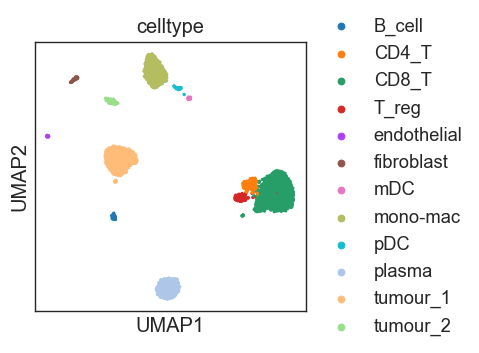

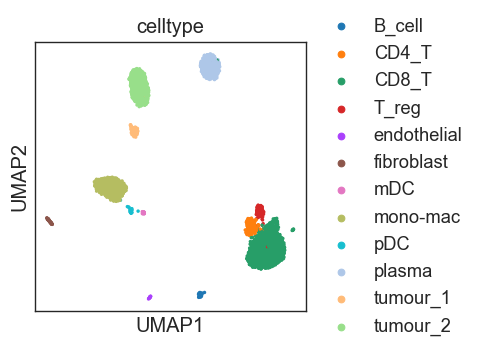

In [13]:
# plot umap
sc.pp.neighbors(stadiff_sim, use_rep="latent", n_neighbors=30)
sc.tl.umap(stadiff_sim, min_dist=0.5)
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sc.pl.umap(stadiff_sim, color="celltype", ax=ax, show=False)
# plot umap
sc.pp.neighbors(stadiff_sim_pseudo, use_rep="latent", n_neighbors=30)
sc.tl.umap(stadiff_sim_pseudo, min_dist=0.5)
fig, ax = plt.subplots(figsize=(3.5, 3.5))
# set stadiff_sim_psudo tumour_1 to pseudotumour_1 and tumour_2 to pseudotumour_2
sc.pl.umap(stadiff_sim_pseudo, color="celltype", ax=ax, show=False)

In [81]:
# concatenate the stadiff_sim and stadiff_sim_psudo
pseudo_tumour = stadiff_sim_pseudo[tumour_indices].copy()
# rename the celltype in pseudo_tumour
pseudo_tumour.obs["celltype"] = pseudo_tumour.obs["celltype"].map({"tumour_1": "pseudotumour_1", "tumour_2": "pseudotumour_2"})
stadiff_sim_concat = sc.concat([stadiff_sim, pseudo_tumour])
# perform pca
sc.tl.pca(stadiff_sim_concat, svd_solver="arpack")
# perform umap
sc.pp.neighbors(stadiff_sim_concat, n_neighbors=15, use_rep="latent")
# plot umap

In [82]:
stadiff_sim_concat_sub = stadiff_sim_concat[stadiff_sim_concat.obs["celltype"].isin(["tumour_1", "tumour_2", "pseudotumour_2"])]
stadiff_sim_concat_sub.obs["celltype"].value_counts()

tumour_1          812
pseudotumour_2    812
tumour_2           87
Name: celltype, dtype: int64

[]

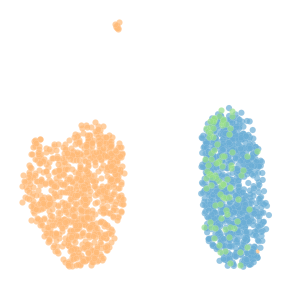

In [84]:
sc.tl.umap(stadiff_sim_concat, min_dist=0.5)
stadiff_sim_concat_sub = stadiff_sim_concat[stadiff_sim_concat.obs["celltype"].isin(["tumour_1", "tumour_2", "pseudotumour_2"])]
umap_df = pd.DataFrame(stadiff_sim_concat_sub.obsm["X_umap"], columns=["UMAP1", "UMAP2"])
umap_df["celltype"] = stadiff_sim_concat_sub.obs["celltype"].values
# plot umap by scatter plot
color_palette = {"tumour_1": sc.pl.palettes.vega_20_scanpy[10],
                 "tumour_2": sc.pl.palettes.vega_20_scanpy[11],
                 # psedutumour should be similar to tumour_2 but slightly lighter
                 "pseudotumour_2": "#6baed6"}
fig, ax = plt.subplots(figsize=(3.5, 3.5))
s=20
for cellteype in ["tumour_1", "pseudotumour_2", "tumour_2"]:
    temp = umap_df[umap_df["celltype"] == cellteype]
    # if celltype contains pseudotumour, then set the edgestyle to dashed
    if "pseudotumour" in cellteype:
        ax.scatter(temp["UMAP1"], temp["UMAP2"], label=cellteype, s=s, c=color_palette[cellteype],
                   edgecolors="white", linewidths=0.1, linestyle="--", alpha=0.7)
    else:
        ax.scatter(temp["UMAP1"], temp["UMAP2"], label=cellteype,
                   s=s, c=color_palette[cellteype], edgecolors="white", linewidths=0.1, alpha=0.7)
# frame off
ax.set_frame_on(False)
# set ticks off
ax.set_xticks([])
ax.set_yticks([])
# save to disk
# fig.savefig("{}/full_umap_sim.png".format(figure_dir), dpi=300)
# show legend

## GO analysis

In [17]:
# pesudo label
import scanpy as sc
from scipy import stats
adata = sc.read_h5ad("{}/adata_processed.h5ad".format(output_root))
stadiff_sim = sc.read_h5ad("{}/full/de/stadiff_1.h5ad".format(output_root))
stadiff_sim_pseudo = sc.read_h5ad("{}/full/de/stadiff_pseudo_1.h5ad".format(output_root))
tumour_sim1  = stadiff_sim[stadiff_sim.obs["celltype"] == "tumour_1"]
tumour_sim2 = stadiff_sim_pseudo[stadiff_sim_pseudo.obs["celltype"] == "tumour_1"]
X_sim1 = tumour_sim1.X
X_sim2 = tumour_sim2.X
print(np.linalg.norm(X_sim1 - X_sim2))
t_stat, p_val = stats.ttest_ind(X_sim1, X_sim2, axis=0)
stadiff_deg = adata.var_names[p_val * 3000  < 0.01]
len(stadiff_deg)

275.87326


2469

In [18]:
mu = np.mean(np.linalg.norm(X_sim1 - X_sim2, axis=0))
sigma = np.std(np.linalg.norm(X_sim1 - X_sim2, axis=0))
gene_list1 = adata.var_names[np.linalg.norm(X_sim1 - X_sim2, axis=0) > mu + 1.5 * sigma].tolist()
len(gene_list1)

172

In [13]:
# using scanpy gene enrichment
stadiff_de_go = sc.queries.enrich(gene_list1, org="hsapiens")
# filter out source that is TF or HP
stadiff_de_go = stadiff_de_go[~stadiff_de_go["source"].isin(["TF", "HP", "WP"])]
stadiff_de_go["log_pval"] = -np.log10(stadiff_de_go["p_value"])

In [14]:
# if contain mela (case not sensitive)
stadiff_de_go

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,log_pval
0,GO:CC,GO:0071944,cell periphery,3.262691e-08,True,"""The broad region around and including the pla...",6228,119,67,22097,0.563025,0.010758,query_1,[GO:0110165],7.486424
1,GO:CC,GO:0045009,chitosome,3.171826e-07,True,"""An intracellular membrane-bounded particle fo...",21,119,6,22097,0.050420,0.285714,query_1,[GO:0031410],6.498691
2,GO:CC,GO:0033162,melanosome membrane,3.171826e-07,True,"""The lipid bilayer surrounding a melanosome."" ...",21,119,6,22097,0.050420,0.285714,query_1,"[GO:0042470, GO:0045009, GO:0090741]",6.498691
3,GO:CC,GO:0090741,pigment granule membrane,3.171826e-07,True,"""Any membrane that is part of a pigment granul...",21,119,6,22097,0.050420,0.285714,query_1,"[GO:0030659, GO:0048770, GO:0098588]",6.498691
5,GO:CC,GO:0030054,cell junction,1.015664e-06,True,"""A cellular component that forms a specialized...",2230,119,35,22097,0.294118,0.015695,query_1,[GO:0110165],5.993250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,KEGG,KEGG:05032,Morphine addiction,4.527439e-02,True,Morphine addiction,89,64,5,8484,0.078125,0.056180,query_1,[KEGG:00000],1.344147
101,GO:BP,GO:0065007,biological regulation,4.540965e-02,True,"""Any process that modulates a measurable attri...",12680,122,95,21031,0.778689,0.007492,query_1,[GO:0008150],1.342852
102,GO:CC,GO:0098984,neuron to neuron synapse,4.826385e-02,True,"""A synapse in which pre and post-synaptic cell...",366,119,9,22097,0.075630,0.024590,query_1,[GO:0045202],1.316378
103,GO:BP,GO:1900024,regulation of substrate adhesion-dependent cel...,4.847207e-02,True,"""Any process that modulates the frequency, rat...",62,122,5,21031,0.040984,0.080645,query_1,"[GO:0010810, GO:0034446]",1.314508


In [17]:
def go_plot_palette(go_df, pattern_dict, unknown_color="grey"):
    plot_palette = dict()
    # interate on the row of go_df
    for i in range(go_df.shape[0]):
        row = go_df.iloc[i]
        # if row matches the pattern_dict, then set the color to the pattern_dict
        matched = False
        for pattern, color in pattern_dict.items():
            if pattern in row["name"].lower():
                plot_palette[row["name"]] = color
                matched = True
        if not matched:
            plot_palette[row["name"]] = unknown_color
    return plot_palette

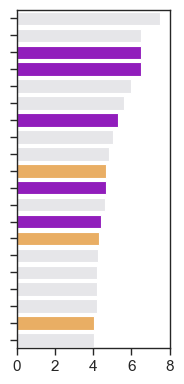

In [18]:
mesen_color = "#FFB14E"
melan_color = "#9D02D7"
unknown_color = "#E5E5E9"
n_terms = 20
sns.set_theme("paper", style="ticks", font_scale=1.25)
figsize = (2, 4)
go_palette = go_plot_palette(stadiff_de_go.head(n_terms), {"mela": melan_color, "extracellular": mesen_color,
                                                      "pig": melan_color, "adhesion": mesen_color}, unknown_color)
# plot bar plot of top 15 go terms with go_palette
fig, ax = plt.subplots(1, 1, figsize=figsize)
# plot dot plot with go_palette horizontally
sns.barplot(data=stadiff_de_go.head(n_terms), y="name", x="log_pval", ax=ax, palette=go_palette,
            orient="h")
# rotate xticklabel
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xlim(0, 8)
ax.set_xticks([0, 2, 4, 6, 8])
ax.set_yticklabels([])
# save to disk
plt.tight_layout()
# fig.savefig("{}/full_stadiff_go.png".format(figure_dir), dpi=300)

# save stadiff_de_go.head(n_terms).name to file
# stadiff_de_go.head(n_terms).name.to_csv("{}/full_stadiff_go.csv".format(figure_dir))

In [21]:
raw_de = sc.get.rank_genes_groups_df(tumour_ad, group="tumour_1", key="raw", pval_cutoff=0.05)
raw_de_genes = raw_de.names.tolist()
raw_de_go = sc.queries.enrich(raw_de_genes, org="hsapiens")
# filter out source that is TF or HP
raw_de_go = raw_de_go[~raw_de_go["source"].isin(["TF", "HP", "WP"])]
raw_de_go["log_pval"] = -np.log10(raw_de_go["p_value"])

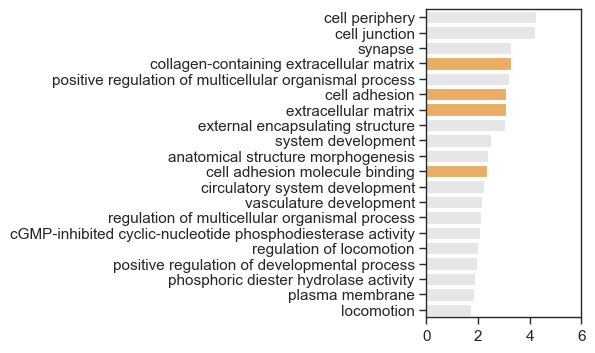

In [22]:
# plotbar plot for raw_de_go
fig, ax = plt.subplots(1, 1, figsize=figsize)
# plot dot plot with go_palette
go_palette= go_plot_palette(raw_de_go.head(n_terms), {"mela": melan_color, "extracellular": mesen_color,
                                                      "pig": melan_color, "adhesion": mesen_color}, unknown_color)
sns.barplot(data=raw_de_go.head(n_terms), y="name", x="log_pval", ax=ax, palette=go_palette, orient="h")
ax.set_xlabel("")
ax.set_ylabel("")
# ax.set_yticklabels([])
# save to disk
ax.set_xticks([0, 2, 4, 6])
plt.tight_layout()
# fig.savefig("{}/full_raw_go.png".format(figure_dir), dpi=300)
# save raw_de_go.head(n_terms).name to file
# raw_de_go.head(n_terms).name.to_csv("{}/full_raw_go.csv".format(figure_dir))
# rotate xticklabels

y 165


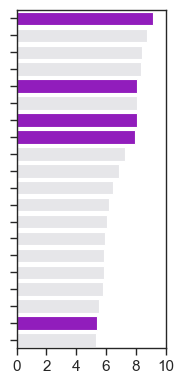

In [23]:
use_covariate = "y"
tumour_1_genes = pd.read_csv("{}/cside_tumour1_genes_{}.csv".format(output_root, use_covariate), index_col=0)
tumour_2_genes = pd.read_csv("{}/cside_tumour2_genes_{}.csv".format(output_root, use_covariate), index_col=0)
top_genes = 100
# keep the top 100 genes by smallest p-value in tumour_1_genes and tumour_2_genes
tumour_1_genes.sort_values("p_val", inplace=True)
tumour_2_genes.sort_values("p_val", inplace=True)
cside_genes = set(tumour_1_genes.iloc[:top_genes].index).union(set(tumour_2_genes.iloc[:top_genes].index))
print(use_covariate, len(cside_genes))
cside_de_go = sc.queries.enrich(list(cside_genes), org="hsapiens")
cside_de_go = cside_de_go[~cside_de_go["source"].isin(["TF", "HP", "WP"])]
cside_de_go["log_pval"] = -np.log10(cside_de_go["p_value"])
# filter out source that is TF or HP
go_palette= go_plot_palette(cside_de_go.head(n_terms), {"mela": melan_color, "extracellular": mesen_color,
                                                      "pig": melan_color, "adhesion": mesen_color}, unknown_color)
# plot
fig, ax = plt.subplots(1, 1, figsize=figsize)
# plot dot plot with go_palette
sns.barplot(data=cside_de_go.head(n_terms), y="name", x="log_pval", ax=ax, palette=go_palette, orient="h")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticklabels([])
ax.set_xticks([0, 2, 4, 6, 8, 10])
# save to disk
plt.tight_layout()
# fig.savefig("{}/full_cside_go_{}.png".format(figure_dir, use_covariate), dpi=300)
# # save cside_de_go.head(n_terms).name to file
# cside_de_go.head(n_terms).name.to_csv("{}/full_cside_go_{}.csv".format(figure_dir, use_covariate))
# # open and write the number of genes in cside_de_go at the end
# with open("{}/full_cside_go_{}.csv".format(figure_dir, use_covariate), "a") as f:
#     f.write("Number of genes: {}\n".format(len(cside_genes)))

## DEG heat map on raw data

In [29]:
cand_genes = set.intersection(set(score_genes["Gene"]), set(adata.var_names))
score_genes = score_genes[score_genes["Gene"].isin(cand_genes)]
melanocytic_genes = score_genes[score_genes["Phenotype"]=="melanocytic"].Gene.tolist()
mesenchymal_genes = score_genes[score_genes["Phenotype"]=="mesenchymal"].Gene.tolist()
stadiff_overlap = set(gene_list1).intersection(set(cand_genes))
raw_overlap = set(raw_de.names).intersection(set(cand_genes))
print("Melanocytic genes: ", len(melanocytic_genes), "Mesenchymal genes: ", len(mesenchymal_genes))
print("Stadiff overlap: ", len(stadiff_overlap), "Raw overlap: ", len(raw_overlap))
# print stadiff overlap with melanocytic genes and mesenchymal genes
print("Stadiff overlap with melanocytic genes: ", len(set(stadiff_overlap).intersection(set(melanocytic_genes))),
      "Stadiff overlap with mesenchymal genes: ", len(set(stadiff_overlap).intersection(set(mesenchymal_genes))))
# print raw overlap with melanocytic genes and mesenchymal genes
print("Raw overlap with melanocytic genes: ", len(set(raw_overlap).intersection(set(melanocytic_genes))),
      "Raw overlap with mesenchymal genes: ", len(set(raw_overlap).intersection(set(mesenchymal_genes))))

Melanocytic genes:  53 Mesenchymal genes:  52
Stadiff overlap:  18 Raw overlap:  9
Stadiff overlap with melanocytic genes:  14 Stadiff overlap with mesenchymal genes:  4
Raw overlap with melanocytic genes:  5 Raw overlap with mesenchymal genes:  4


In [30]:
# score gene
adata.obsm = adata_real_recon.obsm.copy()
tumour_ad = adata[adata.obs["celltype"].isin(["tumour_1", "tumour_2"])].copy()
tumour_ad.X = tumour_ad.X.toarray()
sc.tl.score_genes(tumour_ad, melanocytic_genes, score_name="melanocytic_score")
sc.tl.score_genes(tumour_ad, mesenchymal_genes, score_name="mesenchymal_score")

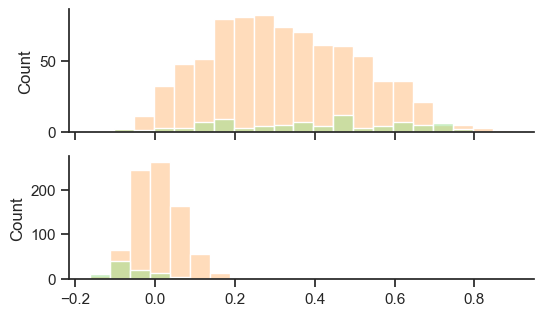

In [341]:
# plot violin plot for melanocytic score
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig, axes = plt.subplots(2, 1, figsize=(6, 3.5), sharex=True)
# plot scatter plot with melanocytic score and mesenchymal score
# plot histogram for melanocytic score for tumour1 and tumour2
sns.histplot(tumour_ad.obs, ax=axes[0], x="melanocytic_score", hue="celltype",
             palette={"tumour_1": sc.pl.palettes.vega_20_scanpy[10],
                      "tumour_2": sc.pl.palettes.vega_20_scanpy[11]},
              hue_order=["tumour_2", "tumour_1"], bins=25, binwidth=0.05)
# add a vertical line at 0
# remove legend
axes[0].get_legend().remove()
sns.histplot(tumour_ad.obs, ax=axes[1], x="mesenchymal_score", hue="celltype",
             palette={"tumour_1": sc.pl.palettes.vega_20_scanpy[10],
                      "tumour_2": sc.pl.palettes.vega_20_scanpy[11]},
              hue_order=["tumour_2", "tumour_1"], binwidth=0.05)
# hide legend
axes[1].get_legend().remove()
axes[1].set_xlabel("")
sns.set_theme(context="paper", style="ticks", font_scale=1.5)

In [31]:
# compute the correlation between melanocytic score and gene expression
mela_score = tumour_ad.obs["melanocytic_score"]
mese_score = tumour_ad.obs["mesenchymal_score"]
# compute the correlation between melanocytic score and gene expression
mela_corr = []
mese_corr = []
for ind in range(tumour_ad.shape[1]):
    mela_corr.append(stats.pearsonr(mela_score, tumour_ad.X[:, ind])[0])
    mese_corr.append(stats.pearsonr(mese_score, tumour_ad.X[:, ind])[0])

In [32]:
gene_score_corr_df = pd.DataFrame({"gene": tumour_ad.var_names, "mela_corr": mela_corr, "mese_corr": mese_corr})
# select gene that is in the gene_list1 as stadiff_deg
gene_score_corr_df["stadiff_deg"] = gene_score_corr_df["gene"].isin(gene_list1)
gene_score_corr_df["raw_deg"] = gene_score_corr_df["gene"].isin(raw_de.names)
gene_score_corr_df['cside_deg'] = gene_score_corr_df['gene'].isin(cside_genes)

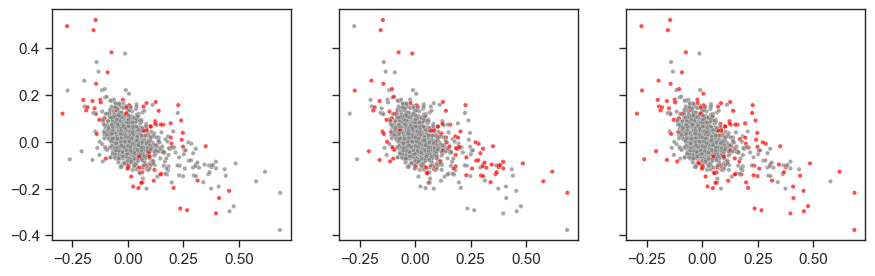

In [246]:
# plot scatter plot for gene_score_corr_df
fig, axes = plt.subplots(1, 3, figsize=(10.5, 3), sharex=True, sharey=True)
# plot scatter plot for mela_corr
sns.scatterplot(data=gene_score_corr_df, x="mela_corr", y="mese_corr", ax=axes[2], hue="stadiff_deg",
                palette={True: "red", False: "grey"}, s=10, alpha=0.7)
# plot scatter plot for mese_corr
sns.scatterplot(data=gene_score_corr_df, x="mela_corr", y="mese_corr", ax=axes[0], hue="raw_deg",
                palette={True: "red", False: "grey"}, s=10, alpha=0.7)
# plot scatter plot for mese_corr
sns.scatterplot(data=gene_score_corr_df, x="mela_corr", y="mese_corr", ax=axes[1], hue="cside_deg",
                palette={True: "red", False: "grey"}, s=10, alpha=0.7)
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    # remove legend
    ax.get_legend().remove()
# adjust hspace
plt.subplots_adjust(hspace=0.25)
# save to disk
fig.savefig("{}/full_gene_score_corr.png".format(figure_dir), dpi=300)

In [259]:
gene_score_corr_df

,gene,mela_corr,mese_corr,stadiff_deg,raw_deg,cside_deg
0,FAM87B,-0.010446,-0.016423,False,False,False
1,KLHL17,0.021951,0.015518,False,False,False
2,PERM1,-0.025991,-0.027892,False,False,False
3,TTLL10,NaN,NaN,False,False,False
4,LINC01786,0.064730,0.013270,False,False,False
...,...,...,...,...,...,...
2995,DKK3,0.002138,0.095536,False,False,False
2996,PODXL,0.011518,0.147987,False,False,False
2997,ITGA2,-0.013160,0.378148,False,False,True
2998,DPYD,-0.274462,0.495566,True,True,False


In [33]:
# test if at least  one of the three columns of gene_score_corr_df are true
gene_score_corr_df_sub_list = []
top_k = 100
for deg_name in ["stadiff", "raw", "cside"]:
    gene_score_corr_df_sub = gene_score_corr_df[gene_score_corr_df["{}_deg".format(deg_name)]]
    gene_score_corr_df_sub["deg_name"] = deg_name
    mela_df_sub = gene_score_corr_df_sub[["gene", "mela_corr"]].copy()
    # get the abs
    mela_df_sub = mela_df_sub.sort_values("mela_corr", ascending=False).head(top_k)
    mela_df_sub = pd.melt(mela_df_sub, id_vars=["gene"], value_vars=["mela_corr"])
    mela_df_sub["method"] = deg_name
    mela_df_sub["score"] = "melanocytic"
    # get the mese_df_sub
    mese_df_sub = gene_score_corr_df_sub[["gene", "mese_corr"]].copy()
    mese_df_sub = mese_df_sub.sort_values("mese_corr", ascending=False).head(top_k)
    mese_df_sub = pd.melt(mese_df_sub, id_vars=["gene"], value_vars=["mese_corr"])
    mese_df_sub["method"] = deg_name
    mese_df_sub["score"] = "mesenchymal"
    gene_score_corr_df_sub_list.append(mela_df_sub)
    gene_score_corr_df_sub_list.append(mese_df_sub)
gene_score_corr_df_sub = pd.concat(gene_score_corr_df_sub_list)

In [48]:
#
from scipy import stats
df_sub = gene_score_corr_df_sub[gene_score_corr_df_sub["score"] == "melanocytic"].copy()
# perform
# stadiff v.s. raw
stadiff_mela = df_sub[df_sub["method"] == "stadiff"]["value"]
cside_mela = df_sub[df_sub["method"] == "cside"]["value"]
raw_mela = df_sub[df_sub["method"] == "raw"]["value"]
print("Melanocytic score comparison:")
t_stat, p_val = stats.wilcoxon(stadiff_mela, raw_mela, alternative="greater")
print("Stadiff v.s. Raw: ", p_val)
# stadiff v.s. cside
t_stat, p_val = stats.wilcoxon(stadiff_mela, cside_mela, alternative="greater")
print("Stadiff v.s. CSIDE: ", p_val)
# raw v.s. cside
t_stat, p_val = stats.wilcoxon(raw_mela, cside_mela)
print("Raw v.s. CSIDE: ", p_val)
print("Mela", raw_mela.mean(), cside_mela.mean(), stadiff_mela.mean())
# Compare the mesenchymal score
df_sub = gene_score_corr_df_sub[gene_score_corr_df_sub["score"] == "mesenchymal"].copy()
# perform wilcoxon test
stadiff_mese = df_sub[df_sub["method"] == "stadiff"]["value"]
cside_mese = df_sub[df_sub["method"] == "cside"]["value"]
raw_mese = df_sub[df_sub["method"] == "raw"]["value"]
print("Mesenchymal score comparison:")
# stadiff v.s. raw
t_stat, p_val = stats.wilcoxon(stadiff_mese, raw_mese, alternative="greater")
print("Stadiff v.s. Raw: ", p_val)
# stadiff v.s. cside
t_stat, p_val = stats.wilcoxon(stadiff_mese, cside_mese, alternative="greater")
print("Stadiff v.s. CSIDE: ", p_val)
# raw v.s. cside
t_stat, p_val = stats.wilcoxon(raw_mese, cside_mese)
print("Raw v.s. CSIDE: ", p_val)
print("Mese", raw_mese.mean(), cside_mese.mean(), stadiff_mese.mean())

Melanocytic score comparison:
Stadiff v.s. Raw:  1.9482799225479546e-18
Stadiff v.s. CSIDE:  2.3117184599803098e-10
Raw v.s. CSIDE:  3.896559845095909e-18
Mela 0.06569972050144839 0.15967336766491078 0.1762354448816038
Mesenchymal score comparison:
Stadiff v.s. Raw:  1.3024877719526746e-17
Stadiff v.s. CSIDE:  1.9775290601188633e-17
Raw v.s. CSIDE:  1.194311046107827e-06
Mese 0.0394455066507643 0.0731632865169619 0.09853962374054817


## Boxplot for score correlation

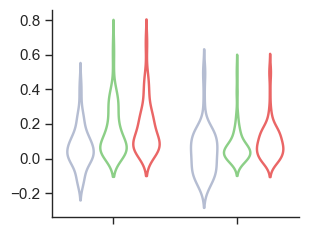

In [61]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.5))
plot_palette = [method_palette["kersplatter"], method_palette["SRT_domain"],
                method_palette["stadiff"]]
# plot boxplot without filling color
ax = sns.violinplot(data=gene_score_corr_df_sub, x="score", y="value", inner=None,
                hue="method", hue_order=["raw", "cside", "stadiff"], ax=ax, scale="width",
                linewidth=1.75, palette=plot_palette, fill=False, gap=0.2)
sns.despine(fig)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.get_legend().remove()
plt.tight_layout()
fig.savefig("{}/full_score_corr_violinplot.png".format(figure_dir), dpi=300)

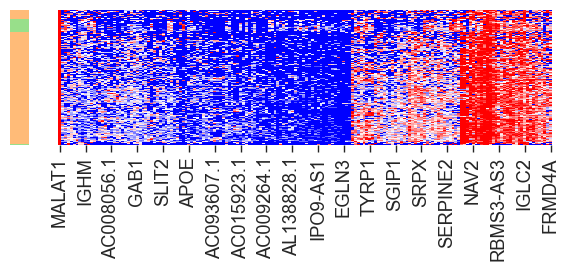

In [21]:
### Heatmpa using the gene list1
# plot gene heat map by the gene list1
from scipy.cluster import hierarchy

adata_sub = adata[adata_raw.obs["celltype"].isin(["tumour_1", "tumour_2"])].copy()
# perform log1p
adata_sub = adata_sub[:, gene_list1].copy()
row_colors = adata_sub.obs["celltype"].to_numpy()
# replace row_colors by tumour_1: red and tumour_2: blue
row_colors[row_colors == "tumour_1"] = sc.plotting.palettes.vega_20_scanpy[10]
row_colors[row_colors == "tumour_2"] = sc.plotting.palettes.vega_20_scanpy[11]
# get dataframe from adata
exp_df = adata_sub.to_df()
np.random.seed(2024)
# clustering row of exp_df
row_cluster = hierarchy.linkage(exp_df, method="average")
# clustering column of exp_df
col_cluster = hierarchy.linkage(exp_df.T, method="average")

cg = sns.clustermap(exp_df, cmap="bwr", figsize=(7.5, 3.5), row_colors=row_colors, vmax=3.25,
                    row_cluster=True, col_cluster=True, row_linkage=row_cluster, col_linkage=col_cluster,
                    yticklabels=False)
# shown_genes_list = set(gene_list1).intersection(set(mesenchymal_genes))
# reordered_labels = exp_df.columns[cg.dendrogram_col.reordered_ind].tolist()
# use_ticks = [reordered_labels.index(gene) + 0.5 for gene in shown_genes_list]
# cg.ax_heatmap.set(xticks=use_ticks, xticklabels=shown_genes_list)
# rotate xticklabels
# hide xticklabels
# only show yticks in gene_list1
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_visible(False)
# hide xticklabels
# remove colorbar
cg.cax.set_visible(False)
plt.tight_layout()

In [55]:
# get the cluters from row_cluster
# get the row cluster k = 3
row_cluster_k3 = hierarchy.fcluster(row_cluster, 44, criterion="maxclust")
adata_sub.obs["hcluster"] = row_cluster_k3
# compute value counts  hcluster and celltype
hcluster_celltype = adata_sub.obs.groupby(["hcluster", "celltype"]).size().unstack().fillna(0)
hcluster_celltype

celltype,tumour_1,tumour_2
hcluster,,
1,2,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,2,0


In [59]:
adata_sub.obs["subpolulation"] = "tumour_1_2"
# set hcluster==28 to tumour_1_1
adata_sub.obs.loc[adata_sub.obs["hcluster"] == 28, "subpolulation"] = "tumour_1_1"
# set celltype == tumour_2 to tumour_2
adata_sub.obs.loc[adata_sub.obs["celltype"] == "tumour_2", "subpolulation"] = "tumour_2"

In [79]:
figure_dir

'../output/App3-SCP2171/_figures'

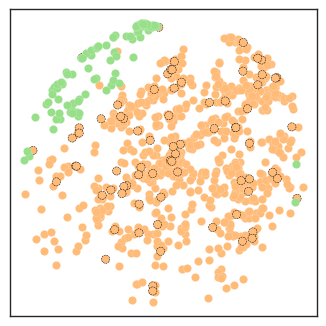

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
s=35
sns.set_style("white")
color_palette = {"tumour_1_1": sc.pl.palettes.vega_20_scanpy[10],
                 "tumour_1_2": sc.pl.palettes.vega_20_scanpy[10],
                 "tumour_2": sc.pl.palettes.vega_20_scanpy[11]}
# plot the scatter of subpolulation by adata_sub.obsm["spatial"]
for subpolulation in ["tumour_1_1", "tumour_1_2", "tumour_2"]:
    temp = adata_sub[adata_sub.obs["subpolulation"] == subpolulation]
    if subpolulation == "tumour_1_2":
    # plot scatter with empty circle
        ax.scatter(temp.obsm["spatial"][:, 0], temp.obsm["spatial"][:, 1], label=subpolulation, s=s,
                   c=color_palette[subpolulation], edgecolors="black", linestyle="dashed", linewidths=0.35)
    else:
        ax.scatter(temp.obsm["spatial"][:, 0], temp.obsm["spatial"][:, 1], label=subpolulation, s=s,
                   c=color_palette[subpolulation], edgecolors="white", linewidths=0.1)
ax.set_xticklabels([])
ax.set_yticklabels([])
# save to disk
plt.tight_layout()
fig.savefig("{}/spatial_subpopulation.png".format(figure_dir), dpi=300)

In [84]:
celltypes = ['CD8_T',
 'T_reg',
 'CD4_T',
 'mono-mac',
 'plasma',
 'pDC',
 'mDC',
 'fibroblast',
 'B_cell',
 'endothelial']

['CD8_T',
 'T_reg',
 'CD4_T',
 'mono-mac',
 'plasma',
 'pDC',
 'mDC',
 'fibroblast',
 'B_cell',
 'endothelial']

In [215]:
from scipy.spatial import cKDTree
spatial = adata.obsm["spatial"]
# compute the average nearest neighbour distance
tree = cKDTree(spatial)
dist, ind = tree.query(spatial, k=2)
# get the average nearest neighbour distance
avg_dist = np.mean(dist[:, 1])
print("Average nearest neighbour distance: ", avg_dist)

Average nearest neighbour distance:  16.000082489047134


In [143]:
def compute_coco(adata, target_spatial, celltypes, radius=16):
    # get the number of target cells within the radius
    tree = cKDTree(target_spatial)
    coco_dict = dict()
    for ct in celltypes:
        # get the spatial of the celltype
        spatial_ct = adata[adata.obs["celltype"] == ct].obsm["spatial"]
        dist, ind = tree.query(spatial_ct, k=1)
        n_target = np.sum(dist < radius)
        coco_dict[ct] = n_target / len(target_spatial)
    return coco_dict

In [152]:
target_spatial = adata_sub[adata_sub.obs["subpolulation"] == "tumour_1_1"].obsm["spatial"]
target_spatial.shape

(737, 2)

In [227]:

# spatial_all is the spatial of tumour_1
spatial_all = adata.obsm["spatial"][adata.obs["celltype"] == "tumour_1"]
target_spatial = adata_sub[adata_sub.obs["subpolulation"] == "tumour_1_1"].obsm["spatial"]
n_target = target_spatial.shape[0]

In [228]:
# compute fold change
celltypes = [
 'B_cell',
 'CD4_T',
 'CD8_T',
 'T_reg',
 'endothelial',
 'fibroblast',
 'mDC',
 'mono-mac',
 'pDC',
 'plasma',]
temp_palette = {ct: sc.pl.palettes.vega_20_scanpy[i] for i, ct in enumerate(celltypes)}


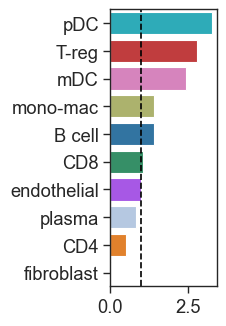

In [244]:
sns.set_style("ticks")
radius = 18
coco_dict1 = compute_coco(adata, target_spatial, celltypes, radius=radius)
coco_df1 = pd.DataFrame(coco_dict1, index=["Tumour_1_1"]).T
coco_dict2 = compute_coco(adata, adata_sub[adata_sub.obs["subpolulation"] == "tumour_1_2"].obsm["spatial"], celltypes,
                          radius=radius)
coco_df2 = pd.DataFrame(coco_dict2, index=["Tumour_1_2"]).T
eps = 1e-5
coco_df1["fold_change"] = (eps + coco_df2["Tumour_1_2"]) / (coco_df1["Tumour_1_1"] + eps)
# plot the fold change
fig, ax = plt.subplots(1, 1, figsize=(2.5, 3.5))
# sorct by fold_change
coco_df2_all = coco_df1.sort_values("fold_change", ascending=False)
sns.barplot(data=coco_df2_all, x="fold_change", y=coco_df2_all.index, ax=ax,
            palette=temp_palette)
# add x=1 line
ax.axvline(1, color="black", linestyle="--")
ax.set_ylabel("")
ax.set_xlabel("")
plt.tight_layout()
# replace xticklabels "T_reg" with "T-reg", "CD4_T" with "CD4", "CD8_T" with "CD8",
# "B_cell" with "B cell"
ax.set_yticklabels(["pDC", "T-reg", "mDC", "mono-mac", "B cell", "CD8",
                    "endothelial", "plasma", "CD4", "fibroblast"])
fig.savefig("{}/full_coco_fold_change.png".format(figure_dir), dpi=300)

In [245]:
coco_df2_all

,Tumour_1_1,fold_change
pDC,0.004071,3.269979
T_reg,0.018996,2.806668
mDC,0.005427,2.453988
mono-mac,0.094980,1.403767
B_cell,0.009498,1.403385
CD8_T,0.352782,1.058255
endothelial,0.000000,1.000000
plasma,0.032564,0.818944
CD4_T,0.025780,0.517380
fibroblast,0.002714,0.003671


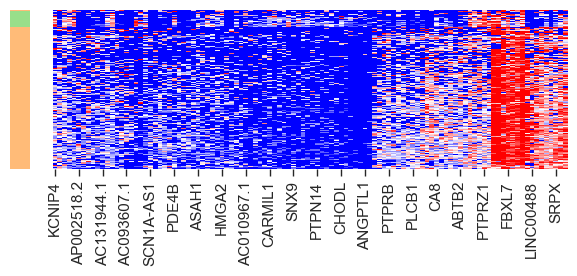

In [86]:
# plot the heatmap for raw_de
adata_sub = adata[adata.obs["celltype"].isin(["tumour_1", "tumour_2"])].copy()
adata_sub = adata_sub[:, raw_de.names].copy()
exp_df = adata_sub.to_df()
np.random.seed(2024)
# clustering row of exp_df
row_cluster = hierarchy.linkage(exp_df, method="average")
# clustering column of exp_df
col_cluster = hierarchy.linkage(exp_df.T, method="average")
cg = sns.clustermap(exp_df, cmap="bwr", figsize=(7.5, 3.5), row_colors=row_colors, vmax=3.25,
                    row_cluster=True, col_cluster=True, row_linkage=row_cluster, col_linkage=col_cluster,
                    yticklabels=False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_visible(False)
cg.cax.set_visible(False)
plt.tight_layout()
cg.savefig("{}/full_raw_deg_heatmap.png".format(figure_dir), dpi=300)

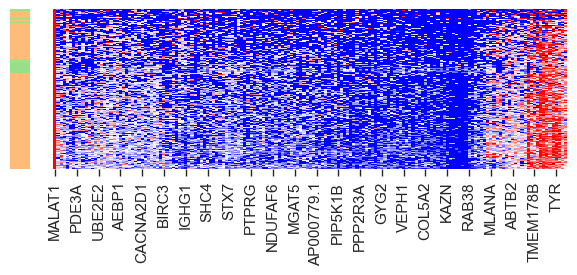

In [89]:
# plot the heatmap for cside_de
adata_sub = adata[adata.obs["celltype"].isin(["tumour_1", "tumour_2"])].copy()
adata_sub = adata_sub[:, list(cside_genes)].copy()
exp_df = adata_sub.to_df()
np.random.seed(2024)
np.random.seed(2024)
# clustering row of exp_df
row_cluster = hierarchy.linkage(exp_df, method="average")
# clustering column of exp_df
col_cluster = hierarchy.linkage(exp_df.T, method="average")
cg = sns.clustermap(exp_df, cmap="bwr", figsize=(7.5, 3.5), row_colors=row_colors, vmax=3.25,
                    row_cluster=True, col_cluster=True, row_linkage=row_cluster, col_linkage=col_cluster,
                    yticklabels=False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_visible(False)
cg.cax.set_visible(False)
plt.tight_layout()
cg.savefig("{}/full_cside_deg_heatmap.png".format(figure_dir), dpi=300)

## Veen diagram of the three methods

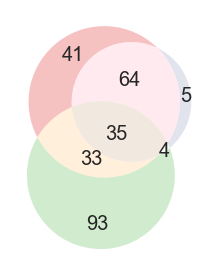

In [741]:
from matplotlib_venn import venn3
# get the number of genes in each method
fig, ax = plt.subplots(1, 1, figsize=(2.75, 3))
vd3 = venn3([set(gene_list1), set(raw_de.names), set(cside_genes)], set_labels=["StaDiff", "Raw", "CSIDE"],
        set_colors=[method_palette["stadiff"], method_palette["kersplatter"], method_palette["SRT_domain"]], ax=ax)
# hide the label of method
for text in vd3.set_labels:
    text.set_visible(False)
plt.tight_layout()
# save to disk
fig.savefig("{}/full_deg_venn.png".format(figure_dir), dpi=300)

In [93]:
# print genes that are only in stadiff
stadiff_only = set(gene_list1).difference(set(raw_de.names).union(set(cside_genes)))
heatmap_shown_genes = ["MALAT1", "AP002518.2", "TMTC1", "LINC00276", "SLIT2SCN1A-AS1", "HTN1", "C3orf85", "AC010967.1", "PLEKHG1", "RUNX2", "CHODL", "ROBO2", "INPP4B", "NPAS3", "SGIP1", "AP001977.1", "NRG3", "SOX5", "CALD1"]
# overlap between stadiff_only and heatmap_shown_genes
print(set(heatmap_shown_genes).intersection(stadiff_only))

{'CALD1', 'C3orf85', 'RUNX2'}


The transcription factor RUNX2 is the osteogenic master gene expressed in mesenchymal stem cells during osteogenic commitment as well as in pre-osteoblasts and early osteoblasts. However, RUNX2 is also ectopically expressed in melanoma and other cancers. Malignant melanoma (MM) is a highly metastatic skin cancer. The incidence of MM has increased considerably in the past half-century. The expression levels and mutation rates of genes such as BRAF, KIT, NRAS, PTEN, P53, TERT and MITF are higher in melanoma than in other solid malignancies. Additionally, transcription factors can affect cellular processes and induce cellular transformation since they control gene expression. Recently, several studies have identified alterations in RUNX2 expression. In particular, the regulation of KIT by RUNX2 and the increased expression of RUNX2 in melanoma specimens have been shown. Melanocytes, whose transformation results in melanoma, arise from the neural crest and therefore show “stemness” features. RUNX2 plays an important role in the re-activation of the MAPK and PI3K/AKT pathways, thus endowing melanoma cells with a high metastatic potential. In melanoma, the most frequent metastatic sites are the lung, liver, brain and lymph nodes. In addition, bone metastatic melanoma has been described. Notably, studies focusing on RUNX2 may contribute to the identification of an appropriate oncotarget in melanoma.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6068731/


# Multioamics analysis

In [446]:
import tqdm
from scanpy.plotting.palettes import vega_20_scanpy
def gtf2df(gtf: str) -> pd.DataFrame:
    """
    Convert a GTF file to a pandas DataFrame.
    Tested with Ensemble GTF files.
    Parameters
    ----------
    gtf : str
        Path to the GTF file.
    Returns
    -------
    df : pandas.DataFrame
    Examples
    --------
    .. highlight:: python
    .. code-block:: python
        df = gtf2df('ensembl.gtf')
        df.head()
    """

    df = pd.read_csv(gtf, sep='\t', header=None, comment='#')
    df.columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

    fields = ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'protein_id', 'exon_id', 'tag']
    for field in fields:
        df[field] = df['attribute'].apply(lambda x: re.findall(rf'{field} "([^"]*)"', x)[0] if rf'{field} "' in x else '')

    df.replace('', np.nan, inplace=True)

    df.drop('attribute', axis=1, inplace=True)


    return df

In [378]:
import pyranges as pr
used_gene_list = adata.var_names.to_list()
# load the tag data
adata_multi, adata_raw_multi = load_slide_tag("../dataset/slide-tag/SCP2171-multiomic", 3000, kept_genes=used_gene_list)
adata_multi = adata_multi[:, used_gene_list].copy()

Raw count shape:  (5704, 90052)


In [379]:
adata_multi_tumour = adata_multi[adata_multi.obs["celltype"].isin(["tumour_1", "tumour_2"])].copy()
adata_multi_tumour_full = adata_multi_tumour.copy()[:, adata.var_names].copy()
adata_multi_tumour = adata_multi_tumour[:, gene_list1].copy()
sc.tl.score_genes(adata_multi_tumour_full, melanocytic_genes, score_name="melanocytic_score")
sc.tl.score_genes(adata_multi_tumour_full, mesenchymal_genes, score_name="mesenchymal_score")

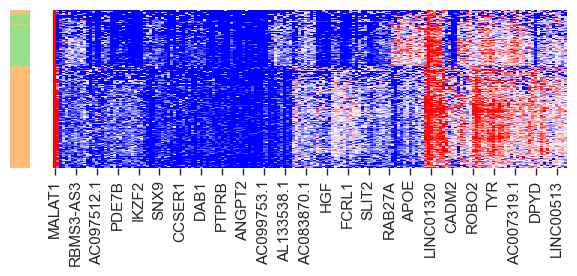

In [384]:
# plot the heatmap for multiomics data
exp_df = adata_multi_tumour.to_df()
np.random.seed(2024)
row_colors = adata_multi_tumour.obs["celltype"].copy().to_numpy()
# replace row_colors by tumour_1: red and tumour_2: blue
row_colors[row_colors == "tumour_1"] = sc.plotting.palettes.vega_20_scanpy[10]
row_colors[row_colors == "tumour_2"] = sc.plotting.palettes.vega_20_scanpy[11]
# clustering row of exp_df
row_cluster = hierarchy.linkage(exp_df, method="average")
# clustering column of exp_df
col_cluster = hierarchy.linkage(exp_df.T, method="average")
cg = sns.clustermap(exp_df, cmap="bwr", figsize=(7.5, 3.5), row_colors=row_colors, vmax=3.25,
                    row_cluster=True, col_cluster=True, row_linkage=row_cluster, col_linkage=col_cluster,
                    yticklabels=False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_visible(False)
cg.cax.set_visible(False)
# save to disk
plt.tight_layout()
cg.savefig("{}/full_multiomics_deg_heatmap.png".format(figure_dir), dpi=300)

In [385]:
# get the row cluster k = 3
row_cluster_k3 = hierarchy.fcluster(row_cluster, 15, criterion="maxclust")
adata_multi_tumour.obs["hcluster"] = row_cluster_k3
# compute value counts  hcluster and celltype
hcluster_celltype = adata_multi_tumour.obs.groupby(["hcluster", "celltype"]).size().unstack().fillna(0)
hcluster_celltype

celltype,tumour_1,tumour_2
hcluster,,
1,2.0,0.0
2,2.0,0.0
3,6.0,0.0
4,6.0,272.0
5,535.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


In [386]:
# assign hcluster [1, 2, 3, 6, 7, 8, 9, 10] to one cluster
adata_multi_tumour.obs["subcelltype"] = adata_multi_tumour.obs["celltype"].copy().astype(str)
# assign hcluster 5 to tumour_1_sub1
adata_multi_tumour.obs.loc[adata_multi_tumour.obs["hcluster"] == 5, "subcelltype"] = "tumour_1_sub1"
# assign the rest of tumour_1 to tumour_1_sub2
adata_multi_tumour.obs["subcelltype"] = adata_multi_tumour.obs["subcelltype"].replace("tumour_1", "tumour_1_sub2")
adata_multi_tumour_full.obs["subcelltype"] = adata_multi_tumour.obs["subcelltype"].copy()
adata_multi_tumour.obs["subcelltype"].value_counts()

tumour_1_sub1    535
tumour_2         272
tumour_1_sub2     26
Name: subcelltype, dtype: int64

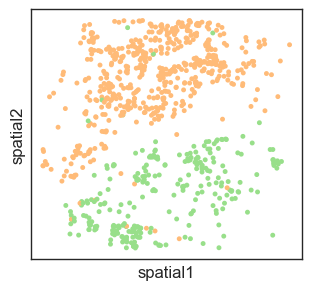

<Figure size 640x480 with 0 Axes>

In [152]:
# plot spatial
fig, ax = plt.subplots(figsize=(3.5, 3.25))
sc.pl.embedding(adata_multi_tumour, basis="spatial", color="celltype",
                palette={"tumour_1": sc.pl.palettes.vega_20_scanpy[10], "tumour_2": sc.pl.palettes.vega_20_scanpy[11]},
                title="", ax=ax, size=50, legend_loc=None)
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
fig.savefig("{}/full_multiomics_spatial.png".format(figure_dir), dpi=300)

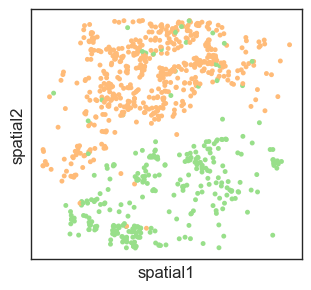

In [205]:
# plot spatial by subcelltype
fig, ax = plt.subplots(figsize=(3.5, 3.25))
sc.pl.embedding(adata_multi_tumour, basis="spatial", color="subcelltype",
                palette={"tumour_1_sub1": sc.pl.palettes.vega_20_scanpy[10],
                         "tumour_1_sub2": sc.pl.palettes.vega_20_scanpy[11],
                         "tumour_2": sc.pl.palettes.vega_20_scanpy[11]},
                title="", ax=ax, size=50, legend_loc=None)

In [270]:
# laod atac-seq data
multi_atacseq = pd.read_csv("../dataset/slide-tag/SCP2171-multiomic/HumanMelanomaMultiome_atac.csv.gz",
                            index_col=0)
ann = pr.read_gff("../dataset/gencode.v45.basic.annotation.gtf.gz")
multi_atacseq.head()
multi_atacseq = multi_atacseq.loc[:, adata_multi_tumour.obs_names.tolist()]
multi_atacseq.head()
atac = sc.AnnData(multi_atacseq.T)
atac.obs["celltype"] = adata_multi_tumour.obs["celltype"].copy()
atac.obs["subcelltype"] = adata_multi_tumour.obs["subcelltype"].copy()
temp = atac.var_names.str.split("-")
atac.var["chr"] = [x[0] for x in temp]
atac.var["start"] = [int(x[1]) for x in temp]
atac.var["end"] = [int(x[2]) for x in temp]
atac.var["gene"] = None

In [290]:
ann = gtf2df("../dataset/gencode.v45.basic.annotation.gtf.gz")

In [332]:
atac_var = atac.var.copy()
def compute_overlap(target_st, target_end, ref_st, ref_end):
    # compute the overlap between (target_st, target_end) and (ref_st, ref_end)
    if target_st >= ref_end or target_end <= ref_st:
        return 0
    else:
        return min(target_end, ref_end) - max(target_st, ref_st)

pbar = tqdm.tqdm(total=atac_var.shape[0])
for row in atac.var.itertuples():
    chr = row.chr
    target_start = row.start
    target_end = row.end
    q = ann.query("seqname == @chr and end <= @target_end and start >= @target_start")
    if len(q) > 0:
        # compute the overlap
        overlap = q.apply(lambda x: compute_overlap(target_start, target_end, x.start, x.end), axis=1)
        q["overlap"] = overlap
        # select the gene with the maximum overlap
        max_overlap = q["overlap"].idxmax()
        atac_var.loc[row.Index, "gene"] = q.loc[max_overlap, "gene_name"]
    pbar.update(1)

100%|█████████▉| 53449/53451 [20:27<00:00, 48.12it/s]

In [334]:
# save atac_var to disk as compressed csv
atac_var.to_csv("{}/annotated_atac.csv.gz".format(output_root), compression="gzip")

In [549]:
multi_atacseq = pd.read_csv("../dataset/slide-tag/SCP2171-multiomic/HumanMelanomaMultiome_atac.csv.gz",
                            index_col=0)
atac_bg = multi_atacseq.loc[:, adata_multi.obs_names.tolist()].copy()
atac_bg = sc.AnnData(atac_bg.T)

In [589]:
atac_bg.var = atac_var.copy()
sub_index = atac_bg.var.gene.isin(gene_list1)
atac_bg_sub = atac_bg[:, sub_index].copy()
atac_bg_melt = pd.melt(atac_bg_sub.to_df(), value_name="value", ignore_index=False)
atac_bg_melt["gene"] = atac_bg_sub.var.loc[atac_bg_melt["variable"], "gene"].to_numpy()
bg_atac_score = atac_bg_melt.groupby("gene").mean()
bg_atac_score.columns = ["bg_score"]


In [352]:
atac.var = atac_var
sub_index = atac.var.gene.isin(gene_list1)
atac_sub = atac[:, sub_index].copy()
# subset by tumour_ad.obs_name
atac_sub = atac_sub[atac_sub.obs_names.isin(adata_multi_tumour.obs_names)].copy()
# subset to gene_list1
# melt atacsub  by row and column index
atac_sub_melt = pd.melt(atac_sub.to_df(), value_name="value", ignore_index=False)
# assign gene by matching the variable column value
atac_sub_melt["gene"] = atac_sub.var.loc[atac_sub_melt["variable"], "gene"].to_numpy()
# assign subcelltype by matching the index of the row
atac_sub_melt["subcelltype"] = adata_multi_tumour.obs.loc[atac_sub_melt.index, "subcelltype"].to_numpy()
atac_sub_melt["subcelltype"].value_counts()


In [505]:
# get gene varible
gene_chr_df = atac_sub.var[["gene", "chr", "start", "end"]].copy()
# using gene as index
gene_chr_df = gene_chr_df.set_index("gene")
# make index unique
gene_chr_df = gene_chr_df[~gene_chr_df.index.duplicated(keep="first")]
df_temp = atac_sub_melt.groupby(["gene", "subcelltype"]).mean().reset_index()
# map gene to chr and start
df_temp = df_temp.merge(gene_chr_df, left_on="gene", right_index=True, how="left")
# convert chr1 to 1
df_temp["chr"] = df_temp["chr"].str.replace("chr", "")
# replace X to 23
df_temp["chr"] = df_temp["chr"].replace("X", 23)
df_temp["chr"] = df_temp["chr"].astype(int)

In [593]:
subdf = df_temp[df_temp["subcelltype"] == "tumour_2"]
# sort subdf by chr and start
subdf = subdf.sort_values(["chr", "start"])
# reset index
subdf = subdf.reset_index(drop=True)
subdf = subdf.merge(bg_atac_score, left_on="gene", right_index=True, how="left")
subdf["fold_change"] = np.log2((subdf["value"] + 1e-5)/ (subdf["bg_score"] + 1e-5))

In [533]:
vline_index = [23.5, #chr1-4
               54.5, #chr5-9
               77.5, #chr10-14
               88.5# chr15-22
               ]

In [641]:
# get subdf dict
subdf_dict = {}
for subcelltype in df_temp["subcelltype"].unique():
    subdf = df_temp[df_temp["subcelltype"] == subcelltype]
    # sort subdf by chr and start
    subdf = subdf.sort_values(["chr", "start"])
    # reset index
    subdf = subdf.reset_index(drop=True)
    subdf_dict[subcelltype] = subdf
tumour_sub1_score = subdf_dict["tumour_1_sub1"]["value"]
tumour_sub2_score = subdf_dict["tumour_1_sub2"]["value"]
tumour_2_score = subdf_dict["tumour_2"]["value"]
score_df = pd.concat([tumour_sub1_score, tumour_sub2_score, tumour_2_score], axis=1)
score_df.columns = ["tumour_1_sub1", "tumour_1_sub2", "tumour_2"]
score_df.index = subdf_dict["tumour_1_sub1"]["gene"]

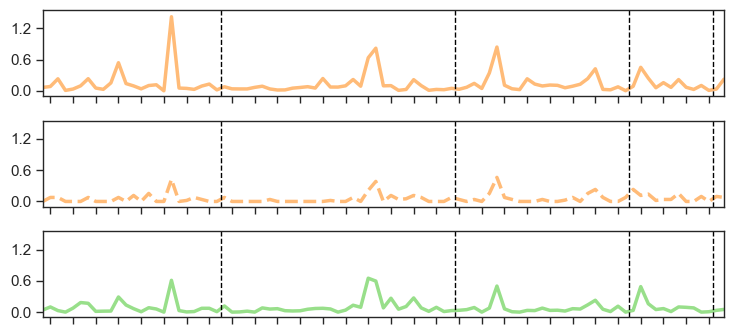

In [655]:
# plot the lin plot by subcelltype aggregated by subcelltype
fig, axes = plt.subplots(3, 1, figsize=(7.5, 3.5), sharex=True, sharey=True)
# sort by chr and start
# plot the line plot for each subcelltype
color = [vega_20_scanpy[10], vega_20_scanpy[10], vega_20_scanpy[11]]
x = range(df_temp[df_temp["subcelltype"] == "tumour_1_sub1"].shape[0])
for ind, subcelltype in enumerate(["tumour_1_sub1", "tumour_1_sub2", "tumour_2"]):
    subdf = subdf_dict[subcelltype]
    # get the index the chr change
    ax = axes[ind]
    if ind == 1:
        linestyle = "--"
    else:
        linestyle = "-"
    ax.plot(x, subdf["value"], color=color[ind], label=subcelltype, linestyle=linestyle,
            linewidth=2.5)
    # add verticl line in chr change
    for i in vline_index:
        ax.axvline(i, color="black", linestyle="--", linewidth=1)
    ax.set_xlim(0, subdf.shape[0] - 1)
# set xticklabels by gene name
axes[0].set_ylim(-0.1, 1.55)
axes[0].set_yticks([0, 0.6, 1.2])
xticks = range(1, subdf.shape[0], 3)
axes[2].set_xticks(np.array(xticks))
axes[2].set_xticklabels([])
# save to disk
plt.tight_layout()
fig.savefig("{}/full_multiomics_atac_lineplots.png".format(figure_dir), dpi=300)

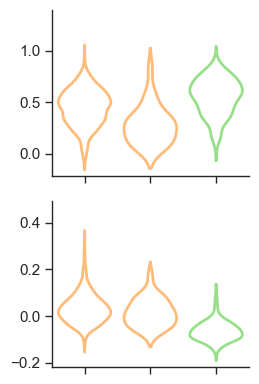

In [730]:
# plot the melanocytic_score and mesenchymal_score by subcelltype in adata_multi_tumour_full
fig, axes = plt.subplots(2, 1, figsize=(2.75, 4), sharex=True)
sns.violinplot(data=adata_multi_tumour_full.obs, x="subcelltype", y="melanocytic_score", ax=axes[0],
                palette={"tumour_1_sub1": vega_20_scanpy[10], "tumour_1_sub2": vega_20_scanpy[10],
                     "tumour_2": vega_20_scanpy[11]}, fill=False,
                order=["tumour_1_sub1", "tumour_1_sub2", "tumour_2"],
                scale="width", inner=None, linewidth=2)

sns.violinplot(data=adata_multi_tumour_full.obs, x="subcelltype", y="mesenchymal_score", ax=axes[1],
               palette={"tumour_1_sub1": vega_20_scanpy[10], "tumour_1_sub2": vega_20_scanpy[10],
                     "tumour_2": vega_20_scanpy[11]}, fill=False, order=["tumour_1_sub1", "tumour_1_sub2", "tumour_2"],
               scale="width", inner=None, linewidth=2)
sns.despine(fig)
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].set_xticklabels([])
# get ylimit
ylim = axes[0].get_ylim()
axes[0].set_ylim(ylim[0], ylim[1] * 1.25)
axes[0].set_ylabel("")
ylim = axes[1].get_ylim()
axes[1].set_ylim(ylim[0], ylim[1] * 1.25)
axes[1].set_ylabel("")
plt.tight_layout()
# adjust h space

In [741]:
import itertools
adata_multi_tumour_full
# wilcoxon test for melanocytic_score and mesenchymal_score
print("Melanocytic score")
for (c1, c2) in itertools.combinations(["tumour_1_sub1", "tumour_1_sub2", "tumour_2"], 2):
    print(" {} v.s. {}".format(c1, c2))
    c1_score = adata_multi_tumour_full.obs.loc[adata_multi_tumour_full.obs["subcelltype"] == c1, "melanocytic_score"]
    c2_score = adata_multi_tumour_full.obs.loc[adata_multi_tumour_full.obs["subcelltype"] == c2, "melanocytic_score"]
    print(stats.ranksums(c1_score, c2_score))
print("Mesenchymal score")
for (c1, c2) in itertools.combinations(["tumour_1_sub1", "tumour_1_sub2", "tumour_2"], 2):
    print(" {} v.s. {}".format(c1, c2))
    c1_score = adata_multi_tumour_full.obs.loc[adata_multi_tumour_full.obs["subcelltype"] == c1, "mesenchymal_score"]
    c2_score = adata_multi_tumour_full.obs.loc[adata_multi_tumour_full.obs["subcelltype"] == c2, "mesenchymal_score"]
    print(stats.ranksums(c1_score, c2_score))

Melanocytic score
 tumour_1_sub1 v.s. tumour_1_sub2
RanksumsResult(statistic=4.649834170119384, pvalue=3.322020244623931e-06)
 tumour_1_sub1 v.s. tumour_2
RanksumsResult(statistic=-7.57036759616898, pvalue=3.72169584841738e-14)
 tumour_1_sub2 v.s. tumour_2
RanksumsResult(statistic=-6.019898167187738, pvalue=1.7452683432535484e-09)
Mesenchymal score
 tumour_1_sub1 v.s. tumour_1_sub2
RanksumsResult(statistic=1.3876403598544391, pvalue=0.16524658515535406)
 tumour_1_sub1 v.s. tumour_2
RanksumsResult(statistic=19.38227507394051, pvalue=1.0892337266617845e-83)
 tumour_1_sub2 v.s. tumour_2
RanksumsResult(statistic=6.374850611552982, pvalue=1.8314138020318482e-10)


# Super resolution

In [ ]:
from stadiffuser.utils import mask_region
missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
n_rep = 5
labels = adata.obs["celltype"].map(class_dict).to_numpy()

for missing_rate in missing_rates:
    print("Missing rate: ", missing_rate)
    mask = "random_{}".format(missing_rate)
    denoiser_masked = torch.load("{}/{}/denoiser_celltype.pth".format(output_root, mask), map_location="cuda:0")
    autoencoder_masked = torch.load("{}/{}/autoencoder_attn2.pth".format(output_root, mask), map_location="cuda:0").to(device)
    new_spatial = adata.obsm["spatial"].copy()
    new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 40), ("division", 40)])
    adata.obsm["new_spatial"] = new_spatial
    adata_masked = mask_region(adata, mask)
    adata_masked_recon = get_recon(adata_masked, autoencoder_masked, device=device, use_net="spatial_net",
                                   apply_normalize=False)
    normalizer = stutils.MinMaxNormalize(adata_masked_recon.obsm["latent"], dim=0)
    data = pipeline.prepare_dataset(adata, device=device, use_net="spatial_net")
    # simulate
    for i in range(1, n_rep+1):
        adata_sim = pipeline.simulate(denoiser_masked, autoencoder_masked, device=device, use_net="spatial_net",
                                      ref_data=adata, spatial_coord=adata.obsm["new_spatial"],
                                      seed=i, normarlizer=normalizer, labels=labels)
        adata_sim.write_h5ad("{}/{}/stadiff_{}.h5ad".format(output_root, mask, i))

In [45]:
stadiff_sim_list = []
srt_sim_list = []
srt_sim_recon_list = []
cond_name = "celltype"
for missing_rate in missing_rates:
    print("Missing rate: ", missing_rate)
    mask = "random_{}".format(missing_rate)
    autoencoder_masked = torch.load("{}/{}/autoencoder_attn2.pth".format(output_root, mask), map_location="cuda:0").to(device)
    stadiff_sim = sc.read_h5ad("{}/{}/stadiff_1.h5ad".format(output_root, mask))
    srt_sim = sc.read_h5ad("{}/{}/SRTSim_fill_inplace1.h5ad".format(output_root, mask))
    # add spatial information
    srt_sim.obsm["spatial"] = adata.obsm["spatial"]
    srt_sim.uns["spatial_net"] = adata.uns["spatial_net"]
    srt_sim.obs_names = adata.obs_names
    srt_sim.obs[cond_name] = adata.obs[cond_name]
    srt_sim_recon = get_recon(srt_sim, autoencoder_masked, device=device, use_net="spatial_net",
                               apply_normalize=True)
    stadiff_sim_list.append(stadiff_sim)
    srt_sim_list.append(srt_sim)
    srt_sim_recon_list.append(srt_sim_recon)

Missing rate:  0.1
Missing rate:  0.2
Missing rate:  0.3
Missing rate:  0.4
Missing rate:  0.5
Missing rate:  0.6
Missing rate:  0.7
Missing rate:  0.8


In [48]:
# compute gene correlation
for ind in range(len(stadiff_sim_list)):
    sc.pp.neighbors(stadiff_sim_list[ind], use_rep="latent", n_neighbors=30)
    sc.tl.umap(stadiff_sim_list[ind], min_dist=0.5)
    sc.pp.neighbors(srt_sim_recon_list[ind], use_rep="latent", n_neighbors=30)
    sc.tl.umap(srt_sim_recon_list[ind], min_dist=0.5)
stadiff_corr_list = [metrics.compute_corr(stadiff_sim, adata_real_recon, dim="gene") for stadiff_sim in stadiff_sim_list]
srt_corr_list = [metrics.compute_corr(srt_sim_recon, adata_real_recon, dim="gene") for srt_sim_recon in srt_sim_recon_list]
stadiff_lsi_list = [metrics.compute_paired_lisi(stadiff_sim, adata_real_recon, use_rep="X_umap") for stadiff_sim in stadiff_sim_list]
srt_lsi_list = [metrics.compute_paired_lisi(srt_sim_recon, adata_real_recon, use_rep="X_umap") for srt_sim_recon in srt_sim_recon_list]

In [60]:
gene_corr_df = pd.DataFrame(np.array(stadiff_corr_list).T)

,0,1,2,3,4,5,6,7
0,0.373963,0.313441,0.267178,0.326881,0.242838,0.300252,0.333913,0.267508
1,0.285310,0.305745,0.084372,0.153337,0.114976,0.224697,0.231516,-0.004246
2,0.311357,0.324977,0.249447,0.264671,0.166335,0.132581,0.163089,0.055850
3,0.197823,0.225946,0.051652,0.203862,0.140948,0.125515,0.094709,0.054611
4,0.204695,0.212987,0.137599,0.228925,0.192299,0.162260,0.136181,0.251752
...,...,...,...,...,...,...,...,...
1995,0.613179,0.694479,0.542247,0.677644,0.652836,0.609742,0.584100,0.675593
1996,0.128595,0.196480,0.092612,0.160967,0.145486,0.118104,0.112397,0.130774
1997,0.094104,0.102810,0.066683,0.053191,-0.007293,-0.012289,0.001749,0.024115
1998,0.209066,0.303975,0.283359,0.321298,0.217142,0.189396,0.246496,0.306977


In [63]:
gene_corr_df = pd.DataFrame(np.array(stadiff_corr_list).T)
gene_corr_df = gene_corr_df.set_index(adata.var_names)
# 3000 genes with respect to the seven missing rates
gene_corr_df = gene_corr_df.set_index(adata.var_names)
# set column names
gene_corr_df.columns = missing_rates
gene_corr_df["method"] = "STADiffuser"
# append srt_corr_list
srt_corr_df = pd.DataFrame(np.array(srt_corr_list).T)
srt_corr_df = srt_corr_df.set_index(adata.var_names)
srt_corr_df.columns = missing_rates
srt_corr_df["method"] = "SRTSim"
# append to gene_corr_df
gene_corr_df = gene_corr_df.append(srt_corr_df)
# metlt the dataframe
gene_corr_df = gene_corr_df.melt(id_vars=["method"], var_name="missing_rate", value_name="gene_corr", ignore_index=False)

,method,missing_rate,gene_corr
FAM87B,STADiffuser,0.1,0.373963
PERM1,STADiffuser,0.1,0.285310
LINC01786,STADiffuser,0.1,0.311357
PRXL2B,STADiffuser,0.1,0.197823
HES2,STADiffuser,0.1,0.204695
...,...,...,...
TTTY10,SRTSim,0.8,0.212229
AC011043.2,SRTSim,0.8,0.050475
AC213203.1,SRTSim,0.8,-0.012708
AC233755.2,SRTSim,0.8,0.085364


In [59]:
# Compute lsi
srt_lsi_df = pd.DataFrame(np.concatenate(stadiff_lsi_list, axis=1))
srt_lsi_df.columns = missing_rates
srt_lsi_df["method"] = "SRTSim"
stadiff_lsi_df = pd.DataFrame(np.concatenate(srt_lsi_list, axis=1))
stadiff_lsi_df.columns = missing_rates
stadiff_lsi_df["method"] = "STADiffuser"
# append to gene_corr_df
lsi_df = srt_lsi_df.append(stadiff_lsi_df)
# del srt_lsi_df, stadiff_lsi_df
# metlt the dataframe keep gene name as the index
lsi_df = lsi_df.melt(id_vars=["method"], var_name="missing_rate", value_name="lsi")

,method,missing_rate,gene_corr
0,STADiffuser,0.1,0.373963
1,STADiffuser,0.1,0.285310
2,STADiffuser,0.1,0.311357
3,STADiffuser,0.1,0.197823
4,STADiffuser,0.1,0.204695
...,...,...,...
31995,SRTSim,0.8,0.212229
31996,SRTSim,0.8,0.050475
31997,SRTSim,0.8,-0.012708
31998,SRTSim,0.8,0.085364


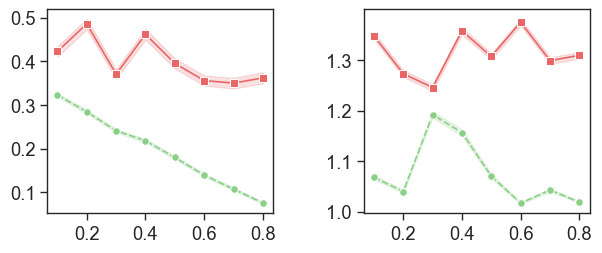

In [81]:
plot_palette = {"STADiffuser": method_palette["stadiff"],
                "SRTSim": method_palette["SRT_domain"]}
fig, axes = plt.subplots(1, 2, figsize=(7, 2.65))
#plot the gene correlation lineplot
ax = axes[0]
sns.lineplot(data=gene_corr_df, x="missing_rate", y="gene_corr", hue="method", ax=ax, style_order=["STADiffuser", "SRTSim"],
             palette=plot_palette, markers=["s", "o"], style="method", ci=95, markersize=5.5)
# remove legend
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
# plot mLISI lineplot
ax = axes[1]
sns.lineplot(data=lsi_df, x="missing_rate", y="lsi", hue="method", ax=ax, style_order=["STADiffuser", "SRTSim"],
             palette=plot_palette, markers=["s", "o"], style="method", ci=95, markersize=5.5)
# remove legend
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
plt.subplots_adjust(wspace=0.4)
# save to figure
fig.savefig("{}/missing_rate_gene_corr_lisi.png".format(figure_dir), dpi=300)

In [86]:
# computet the moran's I for the genes on adata using scanpy on adata
# perform PCA
adata_ = adata.copy()
morans_i = sc.metrics.morans_i(adata)
morans_i = pd.DataFrame(morans_i, index=adata.var_names, columns=["moran_i"])
morans_i

,moran_i
FAM87B,0.001060
PERM1,0.011647
LINC01786,-0.000721
PRXL2B,0.036922
HES2,-0.000843
...,...
TTTY10,0.051249
AC011043.2,-0.000225
AC213203.1,-0.000027
AC233755.2,0.054050


In [8]:
import scanpy as sc
adata = sc.read_h5ad("../dataset/V1_Human_Invasive_Ductal_Carcinoma_10xvisium_processed.h5ad")

In [9]:
adata.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,clusters
AAACAAGTATCTCCCA-1,1,50,102,4215,8.346642,10301.0,9.240093,18.726337,26.395496,35.559654,49.733036,0.0,0.0,0.0,9
AAACAATCTACTAGCA-1,1,3,43,1801,7.496652,2988.0,8.002694,19.210174,27.242303,37.985274,56.459170,0.0,0.0,0.0,8
AAACACCAATAACTGC-1,1,59,19,4180,8.338306,10540.0,9.263028,18.652751,26.944972,36.309298,50.246679,0.0,0.0,0.0,2
AAACAGAGCGACTCCT-1,1,14,94,2986,8.002025,6888.0,8.837681,22.836818,30.516841,39.808362,55.182927,0.0,0.0,0.0,8
AAACAGCTTTCAGAAG-1,1,43,9,3177,8.064007,6883.0,8.836955,18.596542,27.226500,36.887985,52.375418,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,2634,7.876638,5432.0,8.600246,22.349043,29.749632,39.304124,54.639175,0.0,0.0,0.0,1
TTGTTTCATTAGTCTA-1,1,60,30,2437,7.798933,4709.0,8.457443,20.747505,28.902102,38.649395,54.194096,0.0,0.0,0.0,1
TTGTTTCCATACAACT-1,1,45,27,3563,8.178639,8329.0,9.027618,20.338576,28.983071,38.528035,52.467283,0.0,0.0,0.0,2
TTGTTTGTATTACACG-1,1,73,41,1427,7.264030,2222.0,7.706613,22.817282,30.558056,40.369037,58.280828,0.0,0.0,0.0,1
